In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/coleridgeinitiative-show-us-the-data/sample_submission.csv
/kaggle/input/coleridgeinitiative-show-us-the-data/train.csv
/kaggle/input/coleridgeinitiative-show-us-the-data/test/8e6996b4-ca08-4c0b-bed2-aaf07a4c6a60.json
/kaggle/input/coleridgeinitiative-show-us-the-data/test/2100032a-7c33-4bff-97ef-690822c43466.json
/kaggle/input/coleridgeinitiative-show-us-the-data/test/2f392438-e215-4169-bebf-21ac4ff253e1.json
/kaggle/input/coleridgeinitiative-show-us-the-data/test/3f316b38-1a24-45a9-8d8c-4e05a42257c6.json
/kaggle/input/coleridgeinitiative-show-us-the-data/train/f8b03c87-9d1a-4f20-b76b-cb6c69d447b2.json
/kaggle/input/coleridgeinitiative-show-us-the-data/train/585ba241-6348-41ce-a5d2-c9ee434cd64d.json
/kaggle/input/coleridgeinitiative-show-us-the-data/train/bde73ad6-ce46-489b-8ee0-b162698cc6df.json
/kaggle/input/coleridgeinitiative-show-us-the-data/train/c7ce1ac6-36e4-4258-b2e4-1b525dc82ad5.json
/kaggle/input/coleridgeinitiative-show-us-the-data/train/9d75e205-3030-44c6-ae

# Notebooks that I Adapted:

* https://www.kaggle.com/dineshkumaranbalagan/descriptive-analysis

* https://www.kaggle.com/mlconsult/score-57ish-with-additional-govt-datasets

* https://www.kaggle.com/adnaiksachin25/wordcloud-cosine-jaccard-sequencematcher

* https://www.kaggle.com/ht5brer/difference-between-appearing-and-mentioning

* https://www.kaggle.com/armandmorin/show-us-data


# Introduction

## Goal

* The end goal is to do string matching of known datasets names in order to detect mentions of datasets in scientific publications.
* To build a strong NLP model that can infer from context whether or not a piece of text in a publication is refering to the usage of a dataset or not.

# Libraries

In [2]:
import pandas as pd
import numpy as np
import random
import time
import datetime

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

import re
import json
from tqdm.autonotebook import tqdm
import string
import collections
from textblob import TextBlob

import spacy

import nltk
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

from keras.preprocessing import sequence, text
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import utils
from keras.models import *
from keras.layers import *
from keras.callbacks import *
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU
from keras.layers import Dense, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.utils.vis_utils import plot_model

import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  


# Data Description

         - train.csv- CSV file contains metadata of the publications
         - train-JSON file contains publications that are referenced in train.csv
         - test-CSV file contains publications for testing purpose
         - sample_submission.csv-CSV file conatins publications IDs column and prediction columns

**id** - publication id - note that there are multiple rows for some training documents, indicating multiple mentioned datasets.

**pub_title** -title of the publication (a small number of publications have the same title).

**dataset_title** -the title of the dataset that is mentioned within the publication.

**dataset_label** -a portion of the text that indicates the dataset.

**cleaned_label** -the dataset_label, as passed through the clean_text function from the Evaluation page.

**PredictionString** -To be filled with equivalent of cleaned_label of train data

# OBTAIN

### Train Set

In [3]:
#define paths
os.listdir('/kaggle/input/coleridgeinitiative-show-us-the-data/')
train_path = '../input/coleridgeinitiative-show-us-the-data/train'
test_path = '../input/coleridgeinitiative-show-us-the-data/test'

In [4]:
#read train data
train_df = pd.read_csv('../input/coleridgeinitiative-show-us-the-data/train.csv')
train_df.head()

Id  \
0  d0fa7568-7d8e-4db9-870f-f9c6f668c17b   
1  2f26f645-3dec-485d-b68d-f013c9e05e60   
2  c5d5cd2c-59de-4f29-bbb1-6a88c7b52f29   
3  5c9a3bc9-41ba-4574-ad71-e25c1442c8af   
4  c754dec7-c5a3-4337-9892-c02158475064   

                                           pub_title  \
0  The Impact of Dual Enrollment on College Degre...   
1  Educational Attainment of High School Dropouts...   
2  Differences in Outcomes for Female and Male St...   
3  Stepping Stone and Option Value in a Model of ...   
4  Parental Effort, School Resources, and Student...   

                           dataset_title  \
0  National Education Longitudinal Study   
1  National Education Longitudinal Study   
2  National Education Longitudinal Study   
3  National Education Longitudinal Study   
4  National Education Longitudinal Study   

                           dataset_label  \
0  National Education Longitudinal Study   
1  National Education Longitudinal Study   
2  National Education Longitudinal Study   
3  National Education Longitudinal Study   
4  National Education Longitudinal Study   

                           cleaned_label  
0  national education longitudinal study  
1  national education longitudinal study  
2  national education longitudinal study  
3  national education longitudinal study  
4  national education longitudinal study

In [5]:
#create a function to get the text from the JSON file and append it to the new column in table
def read_json_pub(filename, train_path = train_path, output = 'text'):
    json_path = os.path.join(train_path, (filename + '.json'))
    headings = []
    contents = []
    combined = []
    with open(json_path, 'r') as f:
        json_decode = json.load(f)
        for data in json_decode:
            headings.append(data.get('section_title'))
            contents.append(data.get('text'))
            combined.append(data.get('section_title'))
            combined.append(data.get('text'))
    
    all_headings = ' '.join(headings)
    all_contents = ' '.join(contents)
    all_data = '. '.join(combined)
    
    if output == 'text':
        return all_contents
    elif output == 'head':
        return all_headings
    else:
        return all_data

In [6]:
#apply the function to train data
tqdm.pandas()
train_df['text'] = train_df['Id'].progress_apply(read_json_pub)

  0%|          | 0/19661 [00:00<?, ?it/s]

In [7]:
#recheck
train_df.head()

Id  \
0  d0fa7568-7d8e-4db9-870f-f9c6f668c17b   
1  2f26f645-3dec-485d-b68d-f013c9e05e60   
2  c5d5cd2c-59de-4f29-bbb1-6a88c7b52f29   
3  5c9a3bc9-41ba-4574-ad71-e25c1442c8af   
4  c754dec7-c5a3-4337-9892-c02158475064   

                                           pub_title  \
0  The Impact of Dual Enrollment on College Degre...   
1  Educational Attainment of High School Dropouts...   
2  Differences in Outcomes for Female and Male St...   
3  Stepping Stone and Option Value in a Model of ...   
4  Parental Effort, School Resources, and Student...   

                           dataset_title  \
0  National Education Longitudinal Study   
1  National Education Longitudinal Study   
2  National Education Longitudinal Study   
3  National Education Longitudinal Study   
4  National Education Longitudinal Study   

                           dataset_label  \
0  National Education Longitudinal Study   
1  National Education Longitudinal Study   
2  National Education Longitudinal Study   
3  National Education Longitudinal Study   
4  National Education Longitudinal Study   

                           cleaned_label  \
0  national education longitudinal study   
1  national education longitudinal study   
2  national education longitudinal study   
3  national education longitudinal study   
4  national education longitudinal study   

                                                text  
0  This study used data from the National Educati...  
1  Dropping out of high school is not necessarily...  
2   , stress satisfactory outcomes for all youth,...  
3  Federal Reserve Bank of Richmond S1. Accountin...  
4  This article investigates an important factor ...

### Read Submission Data

In [8]:
#read submission data
submission_df = pd.read_csv('../input/coleridgeinitiative-show-us-the-data/sample_submission.csv')

#apply the function to submission data
tqdm.pandas()
submission_df['text'] = submission_df['Id'].progress_apply(read_json_pub)

submission_df.head()

  0%|          | 0/4 [00:00<?, ?it/s]

Id  PredictionString  \
0  2100032a-7c33-4bff-97ef-690822c43466               NaN   
1  2f392438-e215-4169-bebf-21ac4ff253e1               NaN   
2  3f316b38-1a24-45a9-8d8c-4e05a42257c6               NaN   
3  8e6996b4-ca08-4c0b-bed2-aaf07a4c6a60               NaN   

                                                text  
0  Cognitive deficits and reduced educational ach...  
1  This report describes how the education system...  
2  Cape Hatteras National Seashore (CAHA), locate...  
3  A significant body of research has been conduc...

In [9]:
#save
submission_df.to_csv('submission_df.csv')

### Read Samples

In [10]:
#let's read the first sample

import json
with open('../input/coleridgeinitiative-show-us-the-data/train/d0fa7568-7d8e-4db9-870f-f9c6f668c17b.json') as f:
    sample = json.load(f)
    
sample[:2]

[{'section_title': 'What is this study about?',
  'text': 'This study used data from the National Education Longitudinal Study (NELS:88) to examine the effects of dual enrollment programs for high school students on college degree attainment. The study also reported whether the impacts of dual enrollment programs were different for first generation college students versus students whose parents had attended at least some college. In addition, a supplemental analysis reports on the impact of different amounts of dual enrollment course-taking and college degree attainment.\nDual enrollment programs offer college-level learning experiences for high school students. The programs offer college courses and/or the opportunity to earn college credits for students while still in high school.\nThe intervention group in the study was comprised of NELS participants who attended a postsecondary school and who participated in a dual enrollment program while in high school (n = 880). The study author

Within the first section, this publication mentions that they used data from the National Education Longitudinal Study. So the task of this competition is to find string of 'dataset_title' within the 'text' body and return 'cleaned_label'.

In [11]:
#get all 'section_title'
for s in sample:
    print(s['section_title'])

What is this study about?
Features of Dual Enrollment Programs
WWC Single Study Review
WWC Rating
Intervention group
Comparison group
Outcomes and measurement
Support for implementation
Reason for review
Degree attainment
Bachelor's degree attainment
Study Notes:
Glossary of Terms
Multiple comparison adjustment
Quasi-experimental design (QED)
Randomized controlled trial (RCT)
Single-case design (SCD)
Standard deviation


# SCRUB

### Basic Text Cleaning

Before we can create a bag of words or vectorize each document, we need to clean it up and split each document into an array of individual words. Computers are very particular about strings. If we tokenized our data in its current state, we would run into the following problems:

* Counting things that aren't actually words. 
* Punctuation and capitalization would mess up our word counts. We need to remove punctuation and capitalization, so that all words will be counted correctly.

In [12]:
#define stopwords
from nltk.corpus import stopwords
stopwords_list = stopwords.words('english') + list(string.punctuation)
stopwords_list += ["''", '""', '...', '``']

In [13]:
#https://towardsdatascience.com/text-analysis-feature-engineering-with-nlp-502d6ea9225d

def text_cleaning(text, flg_stemm = False, flg_lemm = True, lst_stopwords = None):
    '''
    Converts all text to lower case, tokenize, remove multiple spaces, stopwords, stemming, lemmatize, 
    then convert all back to string
    
    text: string - name of column containing text
    lst_stopwords: list - list of stopwords to remove
    flg_stemm: bool - whether stemming is to be applied
    flg_lemm: bool - whether lemmitisation is to be applied
    '''
    
    #clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    #tokenize (convert from string to list)
    lst_text = text.split()
    
    #remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    stopwords_list]
                
    #stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    #lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    #back to string from list
    text = " ".join(lst_text)
    return text

In [14]:
#clean pub_title text
tqdm.pandas()
train_df['pub_title'] = train_df['pub_title'].progress_apply(text_cleaning)

  0%|          | 0/19661 [00:00<?, ?it/s]

In [15]:
#clean dataset_title text
tqdm.pandas()
train_df['dataset_title'] = train_df['dataset_title'].progress_apply(text_cleaning)

  0%|          | 0/19661 [00:00<?, ?it/s]

In [16]:
#clean train text
tqdm.pandas()
train_df['text'] = train_df['text'].progress_apply(text_cleaning)

  0%|          | 0/19661 [00:00<?, ?it/s]

In [17]:
#review
train_df.head()

Id  \
0  d0fa7568-7d8e-4db9-870f-f9c6f668c17b   
1  2f26f645-3dec-485d-b68d-f013c9e05e60   
2  c5d5cd2c-59de-4f29-bbb1-6a88c7b52f29   
3  5c9a3bc9-41ba-4574-ad71-e25c1442c8af   
4  c754dec7-c5a3-4337-9892-c02158475064   

                                           pub_title  \
0  the impact of dual enrollment on college degre...   
1  educational attainment of high school dropout ...   
2  difference in outcome for female and male stud...   
3  stepping stone and option value in a model of ...   
4  parental effort school resource and student ac...   

                           dataset_title  \
0  national education longitudinal study   
1  national education longitudinal study   
2  national education longitudinal study   
3  national education longitudinal study   
4  national education longitudinal study   

                           dataset_label  \
0  National Education Longitudinal Study   
1  National Education Longitudinal Study   
2  National Education Longitudinal Study   
3  National Education Longitudinal Study   
4  National Education Longitudinal Study   

                           cleaned_label  \
0  national education longitudinal study   
1  national education longitudinal study   
2  national education longitudinal study   
3  national education longitudinal study   
4  national education longitudinal study   

                                                text  
0  this study used data from the national educati...  
1  dropping out of high school is not necessarily...  
2  stress satisfactory outcome for all youth incl...  
3  federal reserve bank of richmond s1 accounting...  
4  this article investigates an important factor ...

In [18]:
#save
train_df.to_csv('train_df.csv')

# EXPLORE

In [19]:
#get info
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19661 entries, 0 to 19660
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Id             19661 non-null  object
 1   pub_title      19661 non-null  object
 2   dataset_title  19661 non-null  object
 3   dataset_label  19661 non-null  object
 4   cleaned_label  19661 non-null  object
 5   text           19661 non-null  object
dtypes: object(6)
memory usage: 921.7+ KB


In [20]:
#check null values
train_df.isnull().sum()

Id               0
pub_title        0
dataset_title    0
dataset_label    0
cleaned_label    0
text             0
dtype: int64

In [21]:
#get summary
train_df.describe()

Id  \
count                                  19661   
unique                                 14316   
top     170113f9-399c-489e-ab53-2faf5c64c5bc   
freq                                      22   

                                     pub_title  \
count                                    19661   
unique                                   14242   
top     science and engineering indicator 2014   
freq                                        22   

                                          dataset_title dataset_label  \
count                                             19661         19661   
unique                                               45           130   
top     alzheimers disease neuroimaging initiative adni          ADNI   
freq                                               6144          3673   

       cleaned_label                                               text  
count          19661                                              19661  
unique           130                                              14301  
top             adni  national science foundation 20 14 national sci...  
freq            3673                                                 22

The Train dataset has 19,661 counts but only 14,316 unique 'Id' in the dataset. This means some 'Id' are duplicates, meaning some 'Id' use multiple datasets.

The 'pub_title' has 19,661 counts but has only 14,271 unique titles. This means some 'pub_titles' are duplicates. There are less 'pub_title' counts than 'Id' counts, meaning some 'pub_title' has multiple 'Id'.

The 'dataset_title' has 19,661 counts but has only 45 unique titles. This means some 'dataset_title' are used many times by different publications.

The 'dataset_label' has 19,661 counts but has only 130 unique labels. This means some 'dataset_label' are duplicates. There are less 'dataset_title' counts than 'dataset_label', meaning some 'dataset_title' are labeled differently by different publications.

In [22]:
print('Number of duplicates in Id:', train_df['Id'].duplicated().sum())
print('Number of duplicates in pub_title:', train_df['pub_title'].duplicated().sum())
print('Number of duplicates in dataset_title:', train_df['dataset_title'].duplicated().sum())
print('Number of duplicates in dataset_label:', train_df['dataset_label'].duplicated().sum())
print('Number of duplicates in cleaned_label:', train_df['cleaned_label'].duplicated().sum())

Number of duplicates in Id: 5345
Number of duplicates in pub_title: 5419
Number of duplicates in dataset_title: 19616
Number of duplicates in dataset_label: 19531
Number of duplicates in cleaned_label: 19531


In [23]:
#check out duplicates
id_duplicates = train_df['Id'] == '170113f9-399c-489e-ab53-2faf5c64c5bc'
train_df.loc[id_duplicates][:10]

Id  \
14795  170113f9-399c-489e-ab53-2faf5c64c5bc   
14796  170113f9-399c-489e-ab53-2faf5c64c5bc   
14797  170113f9-399c-489e-ab53-2faf5c64c5bc   
14798  170113f9-399c-489e-ab53-2faf5c64c5bc   
14799  170113f9-399c-489e-ab53-2faf5c64c5bc   
14800  170113f9-399c-489e-ab53-2faf5c64c5bc   
14801  170113f9-399c-489e-ab53-2faf5c64c5bc   
14802  170113f9-399c-489e-ab53-2faf5c64c5bc   
14803  170113f9-399c-489e-ab53-2faf5c64c5bc   
14804  170113f9-399c-489e-ab53-2faf5c64c5bc   

                                    pub_title  \
14795  science and engineering indicator 2014   
14796  science and engineering indicator 2014   
14797  science and engineering indicator 2014   
14798  science and engineering indicator 2014   
14799  science and engineering indicator 2014   
14800  science and engineering indicator 2014   
14801  science and engineering indicator 2014   
14802  science and engineering indicator 2014   
14803  science and engineering indicator 2014   
14804  science and engineering indicator 2014   

                                           dataset_title  \
14795                    beginning postsecondary student   
14796  survey of science and engineering research fac...   
14797   higher education research and development survey   
14798                         survey of earned doctorate   
14799                         survey of earned doctorate   
14800  survey of science and engineering research fac...   
14801  survey of science and engineering research fac...   
14802                      survey of doctorate recipient   
14803  survey of graduate student and postdoctorates ...   
14804                       education longitudinal study   

                                           dataset_label  \
14795  Beginning Postsecondary Students Longitudinal ...   
14796  National Science Foundation Survey of Science ...   
14797  National Science Foundation Higher Education R...   
14798                        Survey of Earned Doctorates   
14799  National Center for Science and Engineering St...   
14800  Survey of Science and Engineering Research Fac...   
14801  National Center for Science and Engineering St...   
14802                     Survey of Doctorate Recipients   
14803  Survey of Graduate Students and Postdoctorates...   
14804                       Education Longitudinal Study   

                                           cleaned_label  \
14795  beginning postsecondary students longitudinal ...   
14796  national science foundation survey of science ...   
14797  national science foundation higher education r...   
14798                        survey of earned doctorates   
14799  national center for science and engineering st...   
14800  survey of science and engineering research fac...   
14801  national center for science and engineering st...   
14802                     survey of doctorate recipients   
14803  survey of graduate students and postdoctorates...   
14804                       education longitudinal study   

                                                    text  
14795  national science foundation 20 14 national sci...  
14796  national science foundation 20 14 national sci...  
14797  national science foundation 20 14 national sci...  
14798  national science foundation 20 14 national sci...  
14799  national science foundation 20 14 national sci...  
14800  national science foundation 20 14 national sci...  
14801  national science foundation 20 14 national sci...  
14802  national science foundation 20 14 national sci...  
14803  national science foundation 20 14 national sci...  
14804  national science foundation 20 14 national sci...

The same 'Id' and 'pub_title' of sample 14798 and 14799 are labeled differently as 'survey of earned doctorates' and 'national center for science and engineering' although they are the same dataset_title.

In [24]:
#check out duplicates
pub_title_duplicates = train_df['pub_title'] == 'science and engineering indicator 2014'
train_df.loc[pub_title_duplicates][:10]

Id  \
14795  170113f9-399c-489e-ab53-2faf5c64c5bc   
14796  170113f9-399c-489e-ab53-2faf5c64c5bc   
14797  170113f9-399c-489e-ab53-2faf5c64c5bc   
14798  170113f9-399c-489e-ab53-2faf5c64c5bc   
14799  170113f9-399c-489e-ab53-2faf5c64c5bc   
14800  170113f9-399c-489e-ab53-2faf5c64c5bc   
14801  170113f9-399c-489e-ab53-2faf5c64c5bc   
14802  170113f9-399c-489e-ab53-2faf5c64c5bc   
14803  170113f9-399c-489e-ab53-2faf5c64c5bc   
14804  170113f9-399c-489e-ab53-2faf5c64c5bc   

                                    pub_title  \
14795  science and engineering indicator 2014   
14796  science and engineering indicator 2014   
14797  science and engineering indicator 2014   
14798  science and engineering indicator 2014   
14799  science and engineering indicator 2014   
14800  science and engineering indicator 2014   
14801  science and engineering indicator 2014   
14802  science and engineering indicator 2014   
14803  science and engineering indicator 2014   
14804  science and engineering indicator 2014   

                                           dataset_title  \
14795                    beginning postsecondary student   
14796  survey of science and engineering research fac...   
14797   higher education research and development survey   
14798                         survey of earned doctorate   
14799                         survey of earned doctorate   
14800  survey of science and engineering research fac...   
14801  survey of science and engineering research fac...   
14802                      survey of doctorate recipient   
14803  survey of graduate student and postdoctorates ...   
14804                       education longitudinal study   

                                           dataset_label  \
14795  Beginning Postsecondary Students Longitudinal ...   
14796  National Science Foundation Survey of Science ...   
14797  National Science Foundation Higher Education R...   
14798                        Survey of Earned Doctorates   
14799  National Center for Science and Engineering St...   
14800  Survey of Science and Engineering Research Fac...   
14801  National Center for Science and Engineering St...   
14802                     Survey of Doctorate Recipients   
14803  Survey of Graduate Students and Postdoctorates...   
14804                       Education Longitudinal Study   

                                           cleaned_label  \
14795  beginning postsecondary students longitudinal ...   
14796  national science foundation survey of science ...   
14797  national science foundation higher education r...   
14798                        survey of earned doctorates   
14799  national center for science and engineering st...   
14800  survey of science and engineering research fac...   
14801  national center for science and engineering st...   
14802                     survey of doctorate recipients   
14803  survey of graduate students and postdoctorates...   
14804                       education longitudinal study   

                                                    text  
14795  national science foundation 20 14 national sci...  
14796  national science foundation 20 14 national sci...  
14797  national science foundation 20 14 national sci...  
14798  national science foundation 20 14 national sci...  
14799  national science foundation 20 14 national sci...  
14800  national science foundation 20 14 national sci...  
14801  national science foundation 20 14 national sci...  
14802  national science foundation 20 14 national sci...  
14803  national science foundation 20 14 national sci...  
14804  national science foundation 20 14 national sci...

'survey of science and engineering research' dataset_title is labeled differently as 'survey of science and engineering research' and 'national center for science and engineering'

In [25]:
#check out duplicates
dataset_title_duplicates = train_df['dataset_title'] == 'alzheimers disease neuroimaging initiative adni'
train_df.loc[dataset_title_duplicates][:10]

Id  \
437  e6ae91d6-f055-4f4d-ab06-014a0c2c0f19   
438  bbebe836-66f7-4c7a-ad60-64e87e8b5ee8   
439  ba34e841-4e6f-4658-9618-bd947010ac2f   
440  5a8c9c50-58de-4153-aead-ccdd396e801f   
441  1c83573d-d106-4490-b76c-c072f83cf190   
442  ccc05c49-9a90-4b19-9dfb-b3015f34808d   
443  f883954c-5699-4a63-b54c-e8d2645d847a   
444  81f67a82-695f-4975-a0f5-5937f7e4e05c   
445  7c7668d5-b420-4d9f-884c-326b7a5a839d   
446  b248f8ab-53c8-41d8-96c0-bc1114c8c30f   

                                             pub_title  \
437  automated hippocampal segmentation in 3d mri u...   
438  predicting rate of cognitive decline at baseli...   
439  cognitive subscore trajectory prediction in al...   
440  random forest prediction of alzheimers disease...   
441  voxelbased irregularity age map iam for brain ...   
442  evaluation of four supervised learning scheme ...   
443  modeling and predicting ad progression by regr...   
444  evaluating the predictive power of multivariat...   
445  a lifelong learning approach to brain mr segme...   
446  testretest measurement and digital validation ...   

                                       dataset_title  \
437  alzheimers disease neuroimaging initiative adni   
438  alzheimers disease neuroimaging initiative adni   
439  alzheimers disease neuroimaging initiative adni   
440  alzheimers disease neuroimaging initiative adni   
441  alzheimers disease neuroimaging initiative adni   
442  alzheimers disease neuroimaging initiative adni   
443  alzheimers disease neuroimaging initiative adni   
444  alzheimers disease neuroimaging initiative adni   
445  alzheimers disease neuroimaging initiative adni   
446  alzheimers disease neuroimaging initiative adni   

                                  dataset_label  \
437  Alzheimers Disease Neuroimaging Initiative   
438  Alzheimers Disease Neuroimaging Initiative   
439  Alzheimers Disease Neuroimaging Initiative   
440  Alzheimers Disease Neuroimaging Initiative   
441  Alzheimers Disease Neuroimaging Initiative   
442  Alzheimers Disease Neuroimaging Initiative   
443  Alzheimers Disease Neuroimaging Initiative   
444  Alzheimers Disease Neuroimaging Initiative   
445  Alzheimers Disease Neuroimaging Initiative   
446  Alzheimers Disease Neuroimaging Initiative   

                                  cleaned_label  \
437  alzheimers disease neuroimaging initiative   
438  alzheimers disease neuroimaging initiative   
439  alzheimers disease neuroimaging initiative   
440  alzheimers disease neuroimaging initiative   
441  alzheimers disease neuroimaging initiative   
442  alzheimers disease neuroimaging initiative   
443  alzheimers disease neuroimaging initiative   
444  alzheimers disease neuroimaging initiative   
445  alzheimers disease neuroimaging initiative   
446  alzheimers disease neuroimaging initiative   

                                                  text  
437  abstract the automated identification of brain...  
438  this study investigates whether a machinelearn...  
439  accurate diagnosis of alzheimers disease ad en...  
440  timedependent data collected in study of alzhe...  
441  abstractin this paper we propose a novel way t...  
442  abstract we investigated the performance of fo...  
443  alzheimers disease ad is currently attracting ...  
444  prediction of alzheimers disease ad progressio...  
445  abstract convolutional neural network cnns hav...  
446  n euroscience is transforming brain data colle...

Here we see with samples 1450 and 12456, there are same 'text' with same 'Id' and same 'pub_title' but labeled different.

## Look At Dataset Metrics

In [26]:
def get_num_words_per_sample(sample_texts):
    """Returns the median number of words per sample given corpus.

    # Arguments
        sample_texts: list, sample texts.

    # Returns
        int, median number of words per sample.
    """
    num_words = [len(s.split()) for s in sample_texts]
    return np.median(num_words)

print('dataset_title median word count:', get_num_words_per_sample(train_df['dataset_title']))
print('cleaned_label median word count:', get_num_words_per_sample(train_df['cleaned_label']))
print('text median word count:', get_num_words_per_sample(train_df['text']))

dataset_title median word count: 5.0
cleaned_label median word count: 4.0
text median word count: 5089.0


In [27]:
#calculate the number of samples/number of words per sample ratio
len(train_df['dataset_title']) / get_num_words_per_sample(train_df['dataset_title'])

3932.2

## Look At Each Feature Individually

### 'Id'

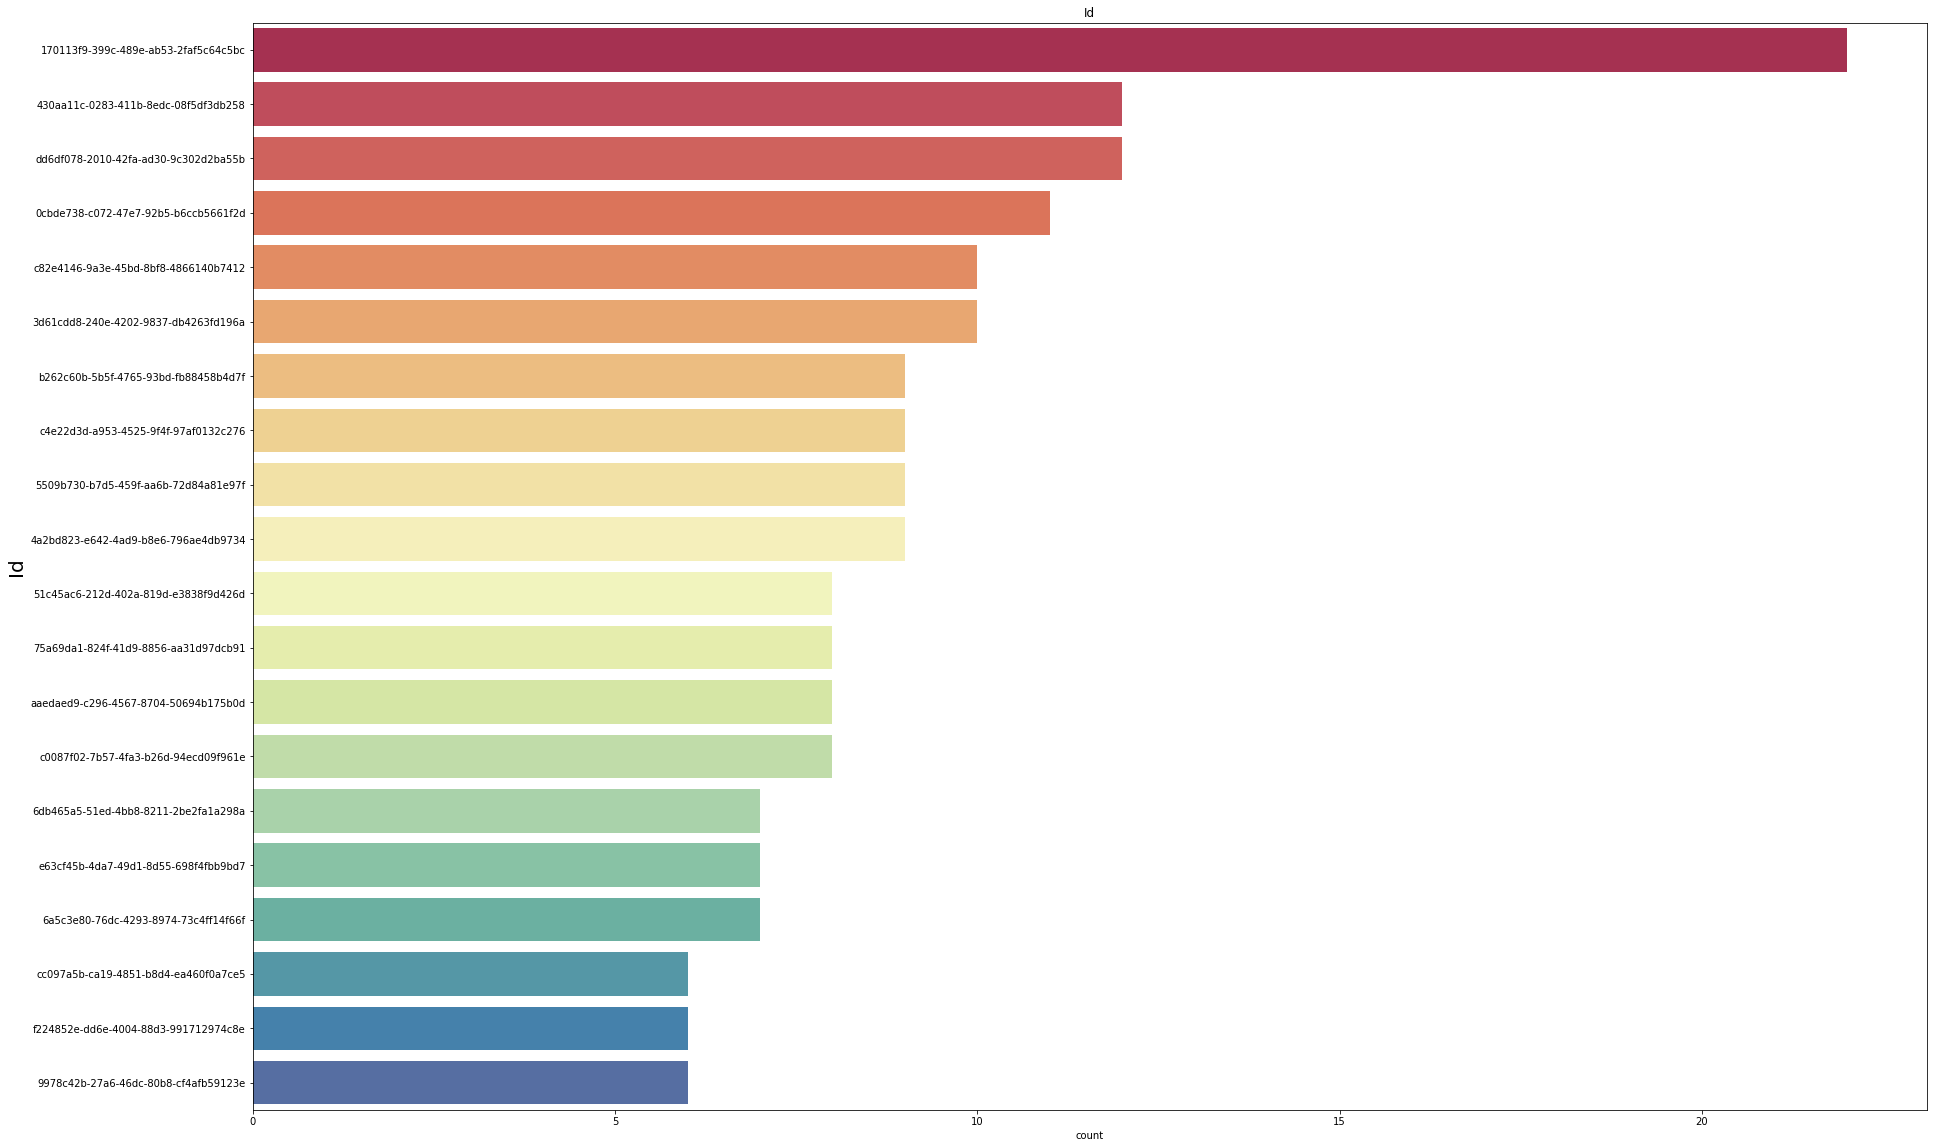

<Figure size 432x288 with 0 Axes>

In [28]:
plt.figure(figsize = (30, 20)),

sns.countplot(y = train_df['Id'], 
              order = train_df['Id'].value_counts(ascending = False)[:20].index, 
              palette = 'Spectral')
plt.ylabel('Id',fontsize = 20)
plt.title('Id')
plt.show()

#save
plt.savefig('Id.png')

### 'pub_title'

In [29]:
train_df['pub_title'].unique()

array(['the impact of dual enrollment on college degree attainment do low student benefit',
       'educational attainment of high school dropout 8 year later issue brief nces 2005026',
       'difference in outcome for female and male student in special education',
       ...,
       'mccs a novel recognition patternbased method for fast track discovery of antisarscov2 drug',
       'quantitative structureactivity relationship machine learning model and their application for identifying viral 3clpro and rdrptargeting compound a potential therapeutic for covid19 and related viral infection',
       'a ligandbased computational drug repurposing pipeline using knime and programmatic data access case study for rare disease and covid19'],
      dtype=object)

In [30]:
train_df['pub_title'].value_counts().head(10).to_frame()

pub_title
science and engineering indicator 2014                     22
science and engineering indicator 2008                     12
digest of education statistic 2012 nces 2014015...         12
science and engineering indicator 2010                     11
program and plan of the national center for edu...         10
program and plan of the national center for edu...         10
nces handbook of survey method technical report             9
program and plan of the national center for edu...          9
program and plan of the national center for edu...          9
program and plan of the national center for edu...          9

In [31]:
#create a frequency distribution to see which words are used the most
words = list( train_df['pub_title'].values)
stopwords = stopwords_list
split_words = []

for word in words:
    lo_w = []
    list_of_words = str(word).split()
    for w in list_of_words:
        if w not in stopwords:
            lo_w.append(w)
    split_words.append(lo_w)
allwords = []

for wordlist in split_words:
    allwords += wordlist
    
#get 100 most common words
mostcommon = FreqDist(allwords).most_common(100)
mostcommon

[('disease', 3071),
 ('alzheimers', 2432),
 ('study', 1728),
 ('analysis', 1407),
 ('cognitive', 1368),
 ('data', 1215),
 ('brain', 1209),
 ('school', 1205),
 ('student', 1204),
 ('using', 1150),
 ('education', 1079),
 ('longitudinal', 979),
 ('effect', 879),
 ('impairment', 820),
 ('model', 784),
 ('learning', 757),
 ('change', 740),
 ('mild', 732),
 ('covid19', 696),
 ('science', 674),
 ('u', 670),
 ('state', 669),
 ('report', 631),
 ('risk', 587),
 ('sarscov2', 587),
 ('impact', 568),
 ('national', 561),
 ('association', 537),
 ('network', 535),
 ('imaging', 530),
 ('early', 522),
 ('research', 497),
 ('achievement', 492),
 ('assessment', 489),
 ('mri', 480),
 ('associated', 473),
 ('biomarkers', 466),
 ('development', 461),
 ('college', 457),
 ('aging', 454),
 ('clinical', 448),
 ('neuroimaging', 432),
 ('among', 422),
 ('united', 409),
 ('adult', 408),
 ('teacher', 406),
 ('nces', 403),
 ('mathematics', 399),
 ('factor', 398),
 ('pattern', 394),
 ('high', 393),
 ('dementia', 393),

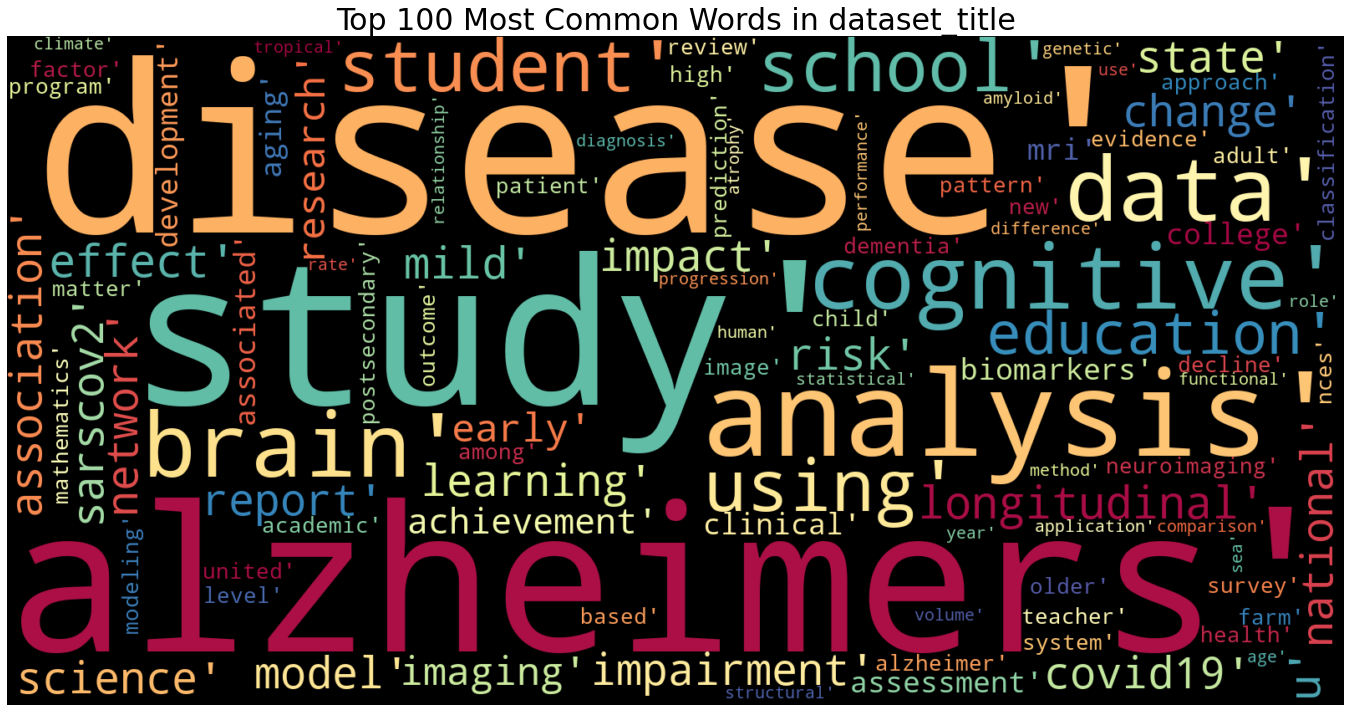

In [32]:
#plot frequency distributions
wordcloud = WordCloud(width = 1600, height = 800, 
                      background_color = 'black', 
                      colormap = 'Spectral', 
                      stopwords = stopwords_list).generate(str(mostcommon))

fig = plt.figure(figsize = (20, 10), facecolor = 'white')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.title('Top 100 Most Common Words in dataset_title', fontsize = 30)
plt.tight_layout()

#save
plt.savefig('pub_title_wordcloud.png')

### 'dataset_title'

In [33]:
train_df['dataset_title'].unique()

array(['national education longitudinal study', 'noaa tide gauge',
       'sea lake and overland surge from hurricane',
       'coastal change analysis program',
       'aging integrated database agid',
       'alzheimers disease neuroimaging initiative adni',
       'baltimore longitudinal study of aging blsa',
       'agricultural resource management survey',
       'beginning postsecondary student',
       'the national institute on aging genetics of alzheimers disease data storage site niagads',
       'common core of data',
       'survey of industrial research and development',
       'baccalaureate and beyond',
       'international best track archive for climate stewardship',
       'national teacher and principal survey',
       'higher education research and development survey',
       'survey of earned doctorate', 'school survey on crime and safety',
       'world ocean database',
       'program for the international assessment of adult competency',
       'early childhood 

In [34]:
train_df['dataset_title'].value_counts().head(20).to_frame()

dataset_title
alzheimers disease neuroimaging initiative adni              6144
baltimore longitudinal study of aging blsa                   1589
trend in international mathematics and science ...           1163
early childhood longitudinal study                           1011
sarscov2 genome sequence                                      860
census of agriculture                                         743
education longitudinal study                                  676
agricultural resource management survey                       660
north american breeding bird survey bb                        585
national education longitudinal study                         550
survey of earned doctorate                                    509
ruralurban continuum code                                     490
beginning postsecondary student                               461
noaa tide gauge                                               441
international best track archive for climate st...            386
common core of data                                           368
world ocean database                                          326
coastal change analysis program                               326
sea lake and overland surge from hurricane                    312
survey of doctorate recipient                                 309

In [35]:
#create a frequency distribution to see which words are used the most
words = list( train_df['dataset_title'].values)
stopwords = stopwords_list
split_words = []

for word in words:
    lo_w = []
    list_of_words = str(word).split()
    for w in list_of_words:
        if w not in stopwords:
            lo_w.append(w)
    split_words.append(lo_w)
allwords = []

for wordlist in split_words:
    allwords += wordlist
    
#get 100 most common words
mostcommon = FreqDist(allwords).most_common(100)
mostcommon

[('disease', 6176),
 ('alzheimers', 6166),
 ('neuroimaging', 6144),
 ('initiative', 6144),
 ('adni', 6144),
 ('study', 5081),
 ('longitudinal', 3918),
 ('survey', 2378),
 ('international', 1618),
 ('aging', 1614),
 ('baltimore', 1589),
 ('blsa', 1589),
 ('education', 1392),
 ('science', 1267),
 ('trend', 1163),
 ('mathematics', 1163),
 ('early', 1011),
 ('childhood', 1011),
 ('sarscov2', 870),
 ('genome', 860),
 ('sequence', 860),
 ('doctorate', 818),
 ('national', 763),
 ('census', 743),
 ('agriculture', 743),
 ('data', 679),
 ('agricultural', 660),
 ('resource', 660),
 ('management', 660),
 ('sea', 600),
 ('north', 585),
 ('american', 585),
 ('breeding', 585),
 ('bird', 585),
 ('bb', 585),
 ('world', 549),
 ('student', 546),
 ('earned', 509),
 ('ruralurban', 490),
 ('continuum', 490),
 ('code', 490),
 ('covid19', 490),
 ('beginning', 461),
 ('postsecondary', 461),
 ('noaa', 441),
 ('tide', 441),
 ('gauge', 441),
 ('dataset', 412),
 ('program', 391),
 ('best', 386),
 ('track', 386),
 

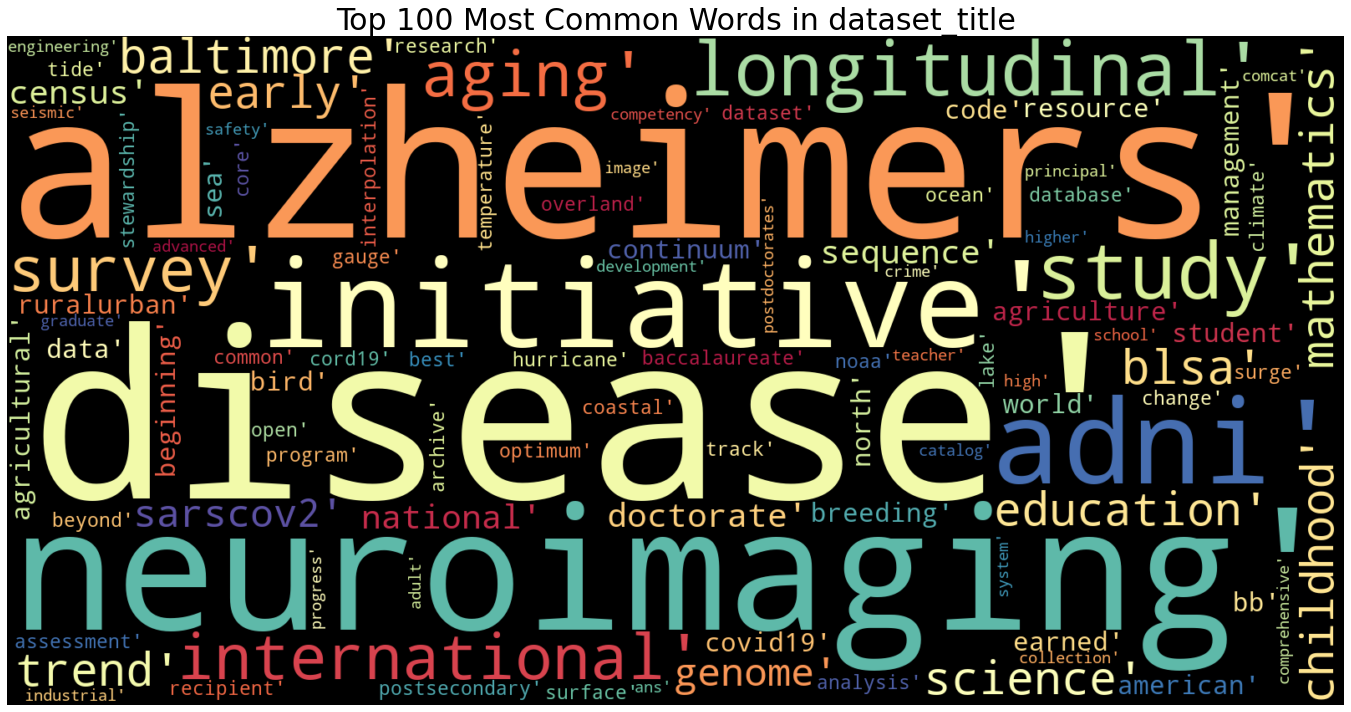

In [36]:
#plot frequency distributions
wordcloud = WordCloud(width = 1600, height = 800, 
                      background_color = 'black', 
                      colormap = 'Spectral', 
                      stopwords = stopwords_list).generate(str(mostcommon))

fig = plt.figure(figsize = (20, 10), facecolor = 'white')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.title('Top 100 Most Common Words in dataset_title', fontsize = 30)
plt.tight_layout()

#save
plt.savefig('dataset_title_wordcloud.png')

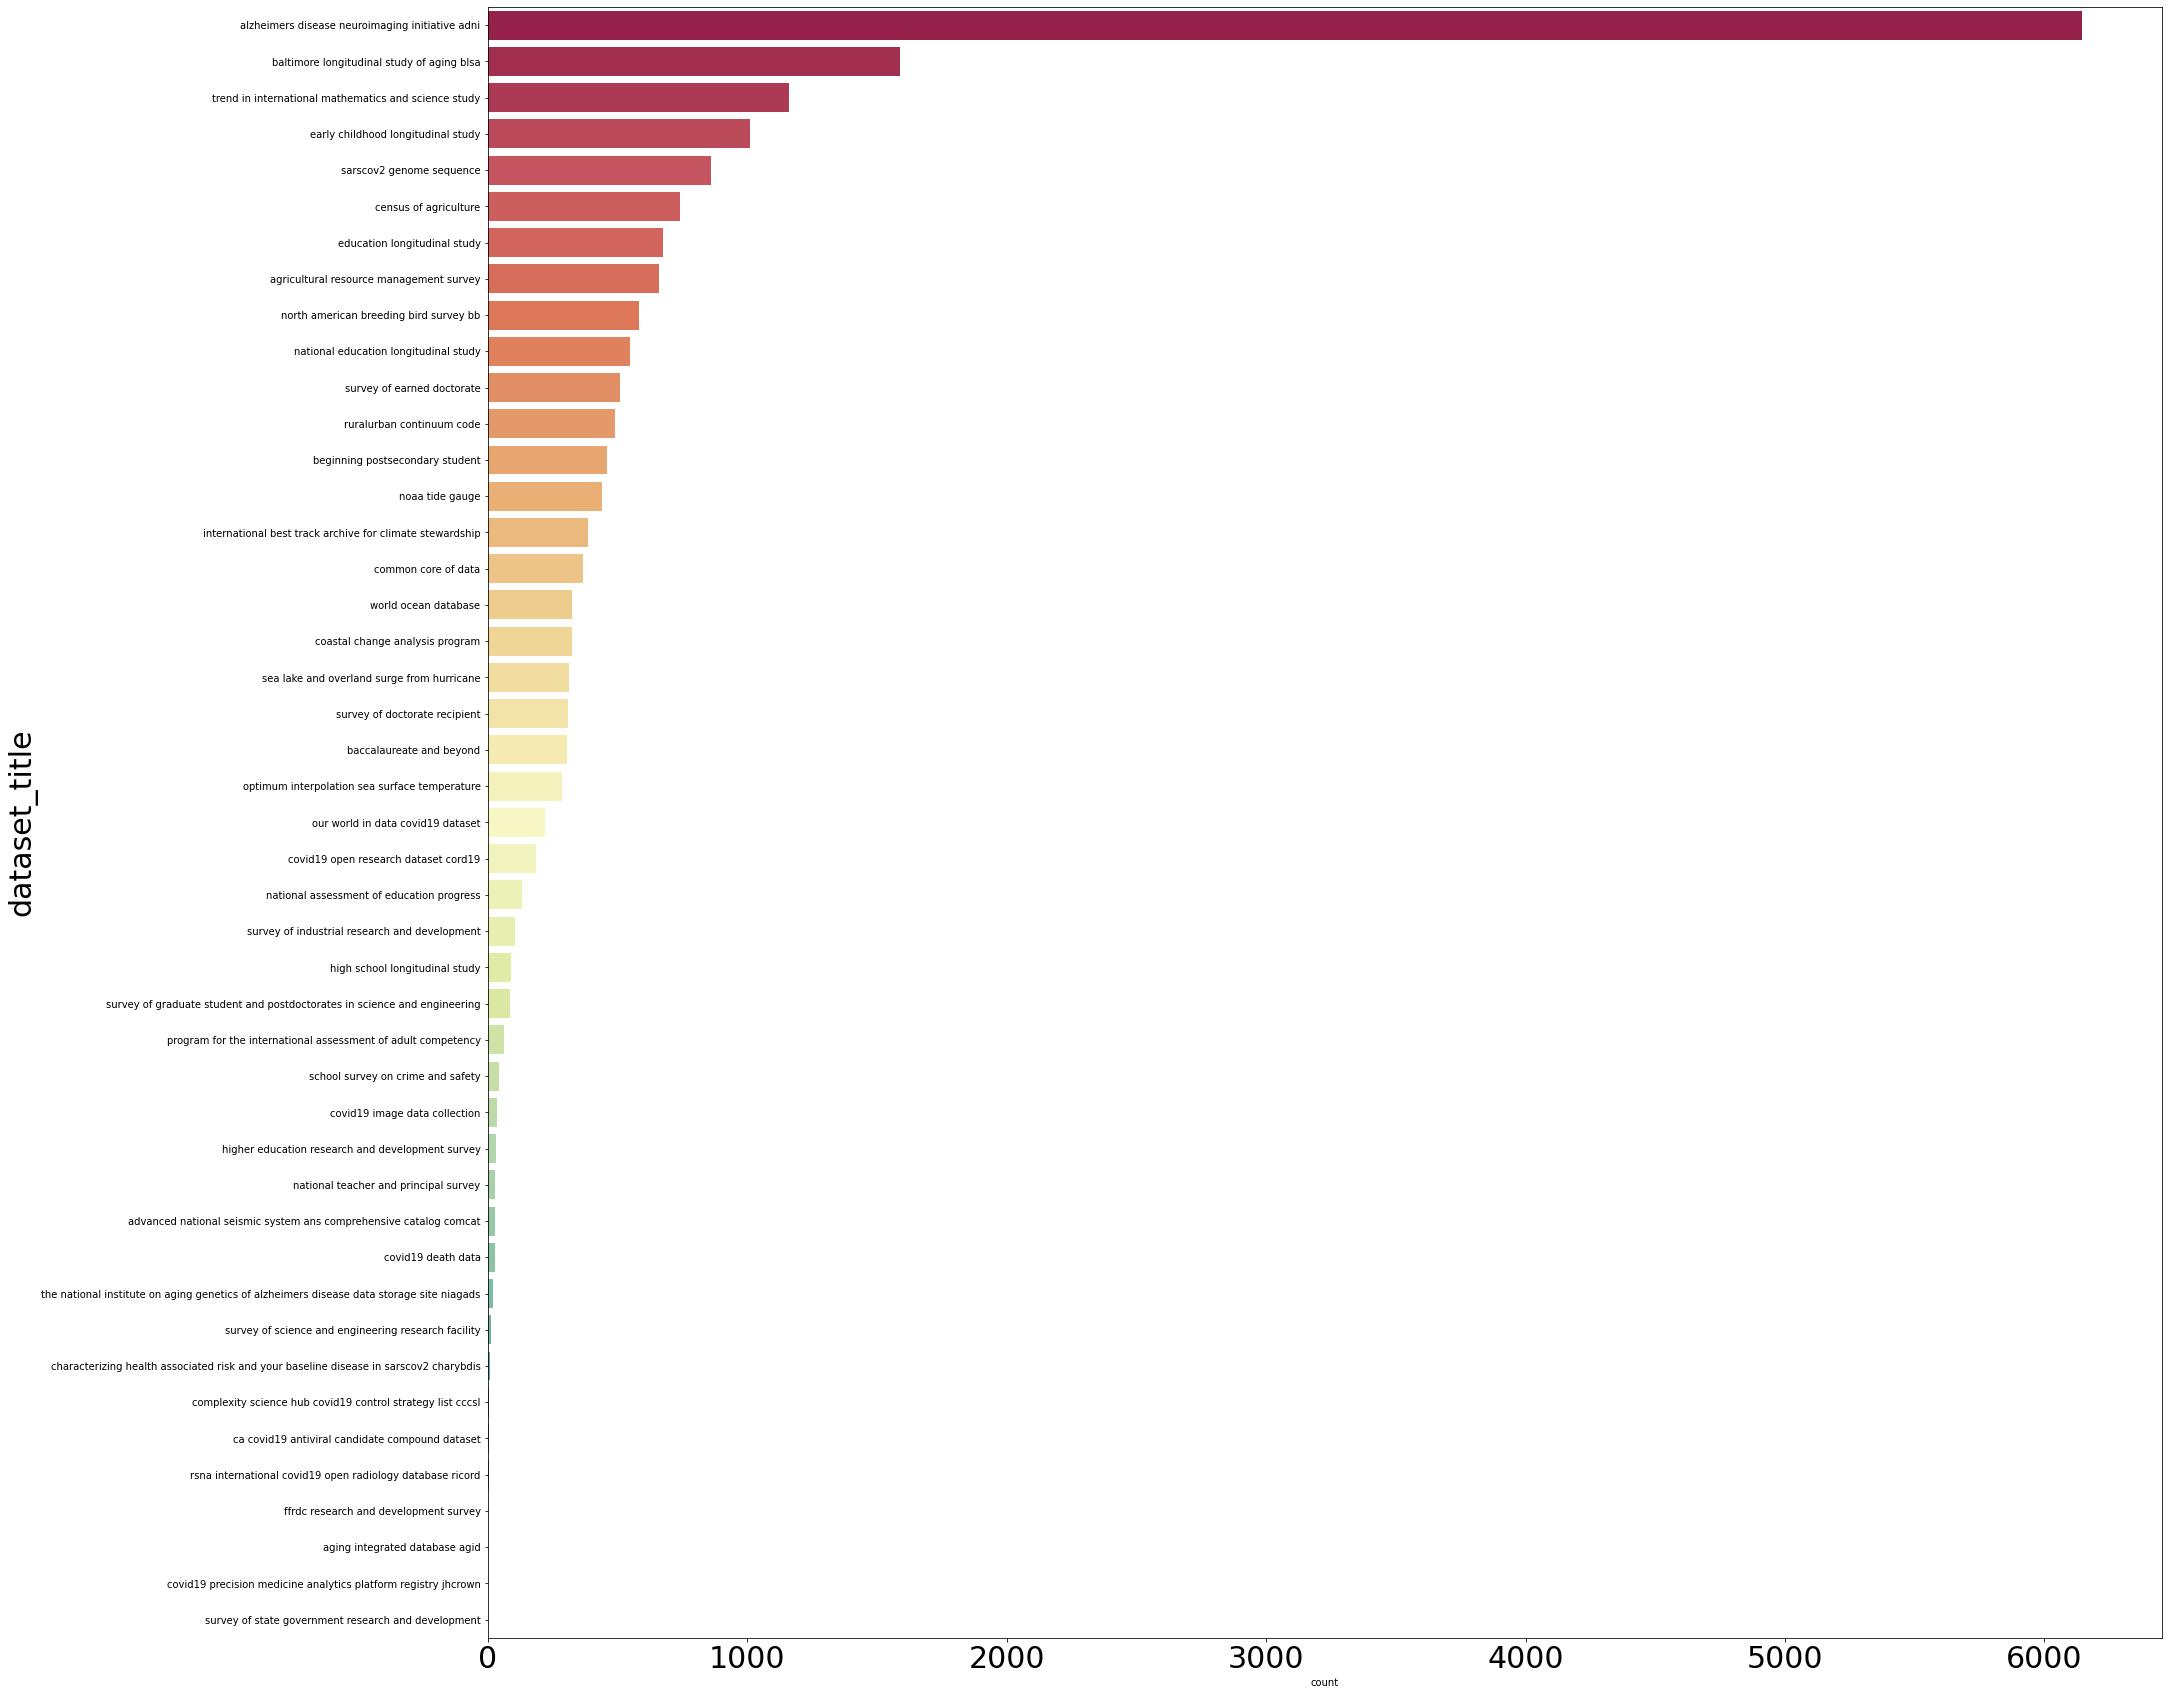

<Figure size 432x288 with 0 Axes>

In [37]:
plt.figure(figsize = (30, 30)),

sns.countplot(y = train_df['dataset_title'], 
              order = train_df['dataset_title'].value_counts().index, 
              palette = 'Spectral')
plt.ylabel('dataset_title',fontsize = 30)
plt.xticks(fontsize = 30)
plt.show()

#save
plt.savefig('dataset_title.png')

## BiGram

In [38]:
from sklearn.feature_extraction.text import CountVectorizer

#get bigrams 
vectorizer = CountVectorizer(ngram_range = (2, 2))

#matrix of ngrams
ngrams = vectorizer.fit_transform(train_df['dataset_title']) 
features = (vectorizer.get_feature_names())
print('\n\nFeatures : \n', features)

#count frequency of ngrams
print('\n\nX1 : \n', ngrams.toarray())
  
#apply TFIDF
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range = (2, 2))
ngrams = vectorizer.fit_transform(train_df['dataset_title'])
scores = (ngrams.toarray())
print('\n\nScores : \n', scores)
  
#get top ranking features
sums = ngrams.sum(axis = 0)
data1 = []
for col, term in enumerate(features):
    data1.append( (term, sums[0,col] ))
ranking = pd.DataFrame(data1, columns = ['term','rank'])
words = (ranking.sort_values('rank', ascending = False))
print ('\n\nWords head : \n', words.head(20))



Features : 
 ['adult competency', 'advanced national', 'aging blsa', 'aging genetics', 'aging integrated', 'agricultural resource', 'alzheimers disease', 'american breeding', 'analysis program', 'analytics platform', 'and beyond', 'and development', 'and engineering', 'and overland', 'and postdoctorates', 'and principal', 'and safety', 'and science', 'and your', 'ans comprehensive', 'antiviral candidate', 'archive for', 'assessment of', 'associated risk', 'baccalaureate and', 'baltimore longitudinal', 'baseline disease', 'beginning postsecondary', 'best track', 'bird survey', 'breeding bird', 'ca covid19', 'candidate compound', 'catalog comcat', 'census of', 'change analysis', 'characterizing health', 'childhood longitudinal', 'climate stewardship', 'coastal change', 'common core', 'complexity science', 'compound dataset', 'comprehensive catalog', 'continuum code', 'control strategy', 'core of', 'covid19 antiviral', 'covid19 control', 'covid19 dataset', 'covid19 death', 'covid19 imag

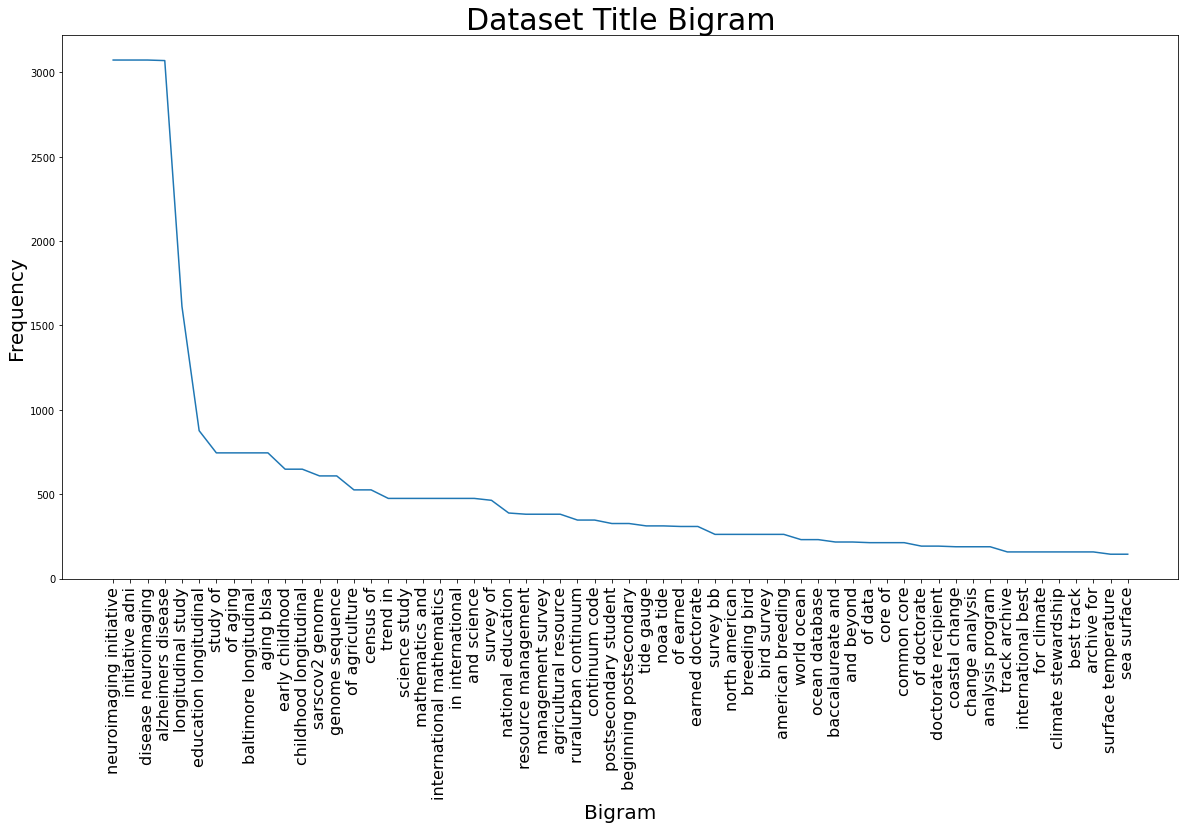

<Figure size 432x288 with 0 Axes>

In [39]:
#count frequency of ngrams
count_values = ngrams.toarray().sum(axis = 0)

#list of ngrams
vocab = vectorizer.vocabulary_
df_bigram = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse = True)
            ).rename(columns = {0: 'frequency', 1: 'bigram'})

plt.figure(figsize = (20, 10))
sns.lineplot(x = df_bigram['bigram'][:60], y = df_bigram['frequency'][:60])
plt.xticks(rotation = 90, fontsize = 16)
plt.xlabel('Bigram',fontsize = 20)
plt.ylabel('Frequency',fontsize = 20)
plt.title('Dataset Title Bigram',fontsize = 30)
plt.show()

#save
plt.savefig('dataset_title_bigram.png')

## TriGram

In [40]:
#get trigrams 
vectorizer = CountVectorizer(ngram_range = (3, 3))

#matrix of ngrams
ngrams = vectorizer.fit_transform(train_df['dataset_title']) 
features = (vectorizer.get_feature_names())
print('\n\nFeatures : \n', features)

#count frequency of ngrams
print('\n\nX1 : \n', ngrams.toarray())
  
#apply TFIDF
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range = (3,3))
ngrams = vectorizer.fit_transform(train_df['dataset_title'])
scores = (ngrams.toarray())
print('\n\nScores : \n', scores)
  
#get top ranking features
sums = ngrams.sum(axis = 0)
data1 = []
for col, term in enumerate(features):
    data1.append( (term, sums[0,col] ))
ranking = pd.DataFrame(data1, columns = ['term','rank'])
words = (ranking.sort_values('rank', ascending = False))
print ('\n\nWords head : \n', words.head(60))



Features : 
 ['advanced national seismic', 'aging genetics of', 'aging integrated database', 'agricultural resource management', 'alzheimers disease data', 'alzheimers disease neuroimaging', 'american breeding bird', 'analytics platform registry', 'and development survey', 'and engineering research', 'and overland surge', 'and postdoctorates in', 'and principal survey', 'and science study', 'and your baseline', 'ans comprehensive catalog', 'antiviral candidate compound', 'archive for climate', 'assessment of adult', 'assessment of education', 'associated risk and', 'baccalaureate and beyond', 'baltimore longitudinal study', 'baseline disease in', 'beginning postsecondary student', 'best track archive', 'bird survey bb', 'breeding bird survey', 'ca covid19 antiviral', 'candidate compound dataset', 'census of agriculture', 'change analysis program', 'characterizing health associated', 'childhood longitudinal study', 'coastal change analysis', 'common core of', 'complexity science hub',

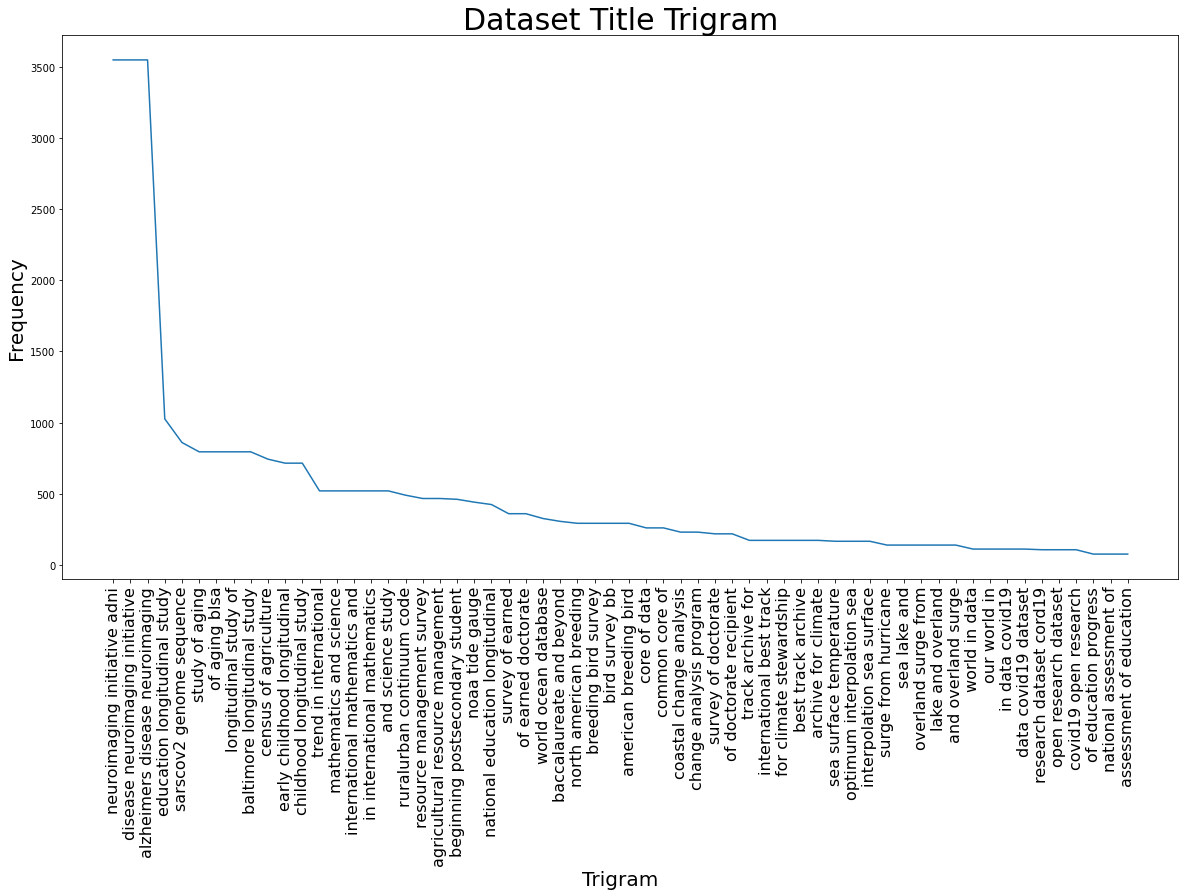

<Figure size 432x288 with 0 Axes>

In [41]:
#count frequency of ngrams
count_values = ngrams.toarray().sum(axis = 0)

#list of ngrams
vocab = vectorizer.vocabulary_
df_trigram = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse = True)
            ).rename(columns = {0: 'frequency', 1:'trigram'})

plt.figure(figsize = (20, 10))
sns.lineplot(x = df_trigram['trigram'][:60], y = df_trigram['frequency'][:60])
plt.xticks(rotation = 90, fontsize = 16)
plt.xlabel('Trigram',fontsize = 20)
plt.ylabel('Frequency',fontsize = 20)
plt.title('Dataset Title Trigram',fontsize = 30)
plt.show()

#save
plt.savefig('dataset_title_trigram.png')

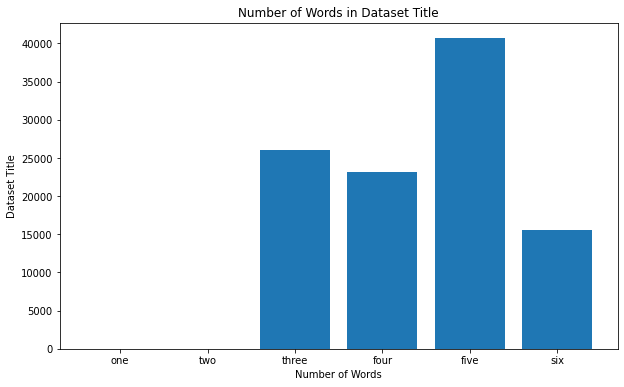

In [42]:
#find one-worded, two-worded, three-worded, four-worded, five-worded dataset title
one_worded_dataset_title = train_df[train_df['dataset_title'].str.split().apply(len) == 1]
two_worded_dataset_title = train_df[train_df['dataset_title'].str.split().apply(len) == 2]
three_worded_dataset_title = train_df[train_df['dataset_title'].str.split().apply(len) == 3]
four_worded_dataset_title = train_df[train_df['dataset_title'].str.split().apply(len) == 4]
five_worded_dataset_title = train_df[train_df['dataset_title'].str.split().apply(len) == 5]
six_worded_dataset_title = train_df[train_df['dataset_title'].str.split().apply(len) == 6]

#create a bar plot
fig, ax = plt.subplots(figsize = (10, 6))
ax.bar([1, 2, 3, 4, 5, 6], [one_worded_dataset_title.size,
                         two_worded_dataset_title.size,
                         three_worded_dataset_title.size,
                         four_worded_dataset_title.size,
                         five_worded_dataset_title.size,
                            six_worded_dataset_title.size])

#label the x-axis instances
ax.set_xticks([1, 2, 3, 4, 5, 6])
ax.set_xticklabels(["one", "two", "three", 'four', 'five', 'six'])

# set the title and the xy-axis labels
plt.title("Number of Words in Dataset Title")
plt.xlabel("Number of Words")
plt.ylabel("Dataset Title")

# display the plot
plt.show()

### 'cleaned_label'

In [43]:
train_df['cleaned_label'].unique()

array(['national education longitudinal study', 'noaa tidal station',
       'slosh model', 'noaa c cap', 'aging integrated database agid ',
       'alzheimers disease neuroimaging initiative',
       'aging integrated database',
       'noaa national water level observation network',
       'noaa water level station',
       'baltimore longitudinal study of aging blsa ',
       'national water level observation network',
       'arms farm financial and crop production practices',
       'beginning postsecondary student',
       'noaa sea lake and overland surges from hurricanes',
       'noaa tide gauge',
       'the national institute on aging genetics of alzheimer s disease data storage site',
       'national center for education statistics common core of data',
       'national science foundation survey of industrial research and development',
       'baccalaureate and beyond',
       'noaa international best track archive for climate stewardship',
       'agricultural resource ma

In [44]:
train_df['cleaned_label'].value_counts().head(20).to_frame()

cleaned_label
adni                                                         3673
alzheimer s disease neuroimaging initiative adni             2400
trends in international mathematics and science...           1163
baltimore longitudinal study of aging                        1156
early childhood longitudinal study                           1011
education longitudinal study                                  676
census of agriculture                                         643
agricultural resource management survey                       623
national education longitudinal study                         550
rural urban continuum codes                                   490
baltimore longitudinal study of aging blsa                    433
survey of earned doctorates                                   428
north american breeding bird survey                           380
world ocean database                                          314
slosh model                                                   304
noaa tide gauge                                               299
survey of doctorate recipients                                298
ibtracs                                                       280
coastal change analysis program                               255
common core of data                                           252

### Frequency Distributions

In [45]:
#create a frequency distribution to see which words are used the most
words = list( train_df['cleaned_label'].values)
stopwords = stopwords_list
split_words = []
for word in words:
    lo_w = []
    list_of_words = str(word).split()
    for w in list_of_words:
        if w not in stopwords:
            lo_w.append(w)
    split_words.append(lo_w)
allwords = []
for wordlist in split_words:
    allwords += wordlist
    
#get 100 most common words
mostcommon = FreqDist(allwords).most_common(100)
mostcommon

[('adni', 6073),
 ('study', 5338),
 ('longitudinal', 4175),
 ('disease', 2503),
 ('neuroimaging', 2471),
 ('initiative', 2471),
 ('alzheimer', 2422),
 ('survey', 2365),
 ('aging', 1614),
 ('baltimore', 1589),
 ('education', 1447),
 ('international', 1338),
 ('science', 1316),
 ('trends', 1163),
 ('mathematics', 1163),
 ('early', 1011),
 ('childhood', 1011),
 ('national', 936),
 ('genome', 860),
 ('sars', 804),
 ('cov', 804),
 ('2', 804),
 ('census', 743),
 ('agriculture', 743),
 ('data', 686),
 ('agricultural', 647),
 ('management', 647),
 ('resource', 623),
 ('north', 585),
 ('american', 585),
 ('breeding', 585),
 ('bird', 585),
 ('world', 549),
 ('noaa', 548),
 ('earned', 509),
 ('doctorates', 509),
 ('rural', 490),
 ('urban', 490),
 ('continuum', 490),
 ('codes', 490),
 ('students', 476),
 ('sequences', 462),
 ('beginning', 461),
 ('postsecondary', 461),
 ('blsa', 433),
 ('sequence', 398),
 ('common', 368),
 ('core', 368),
 ('19', 362),
 ('research', 341),
 ('tide', 334),
 ('databas

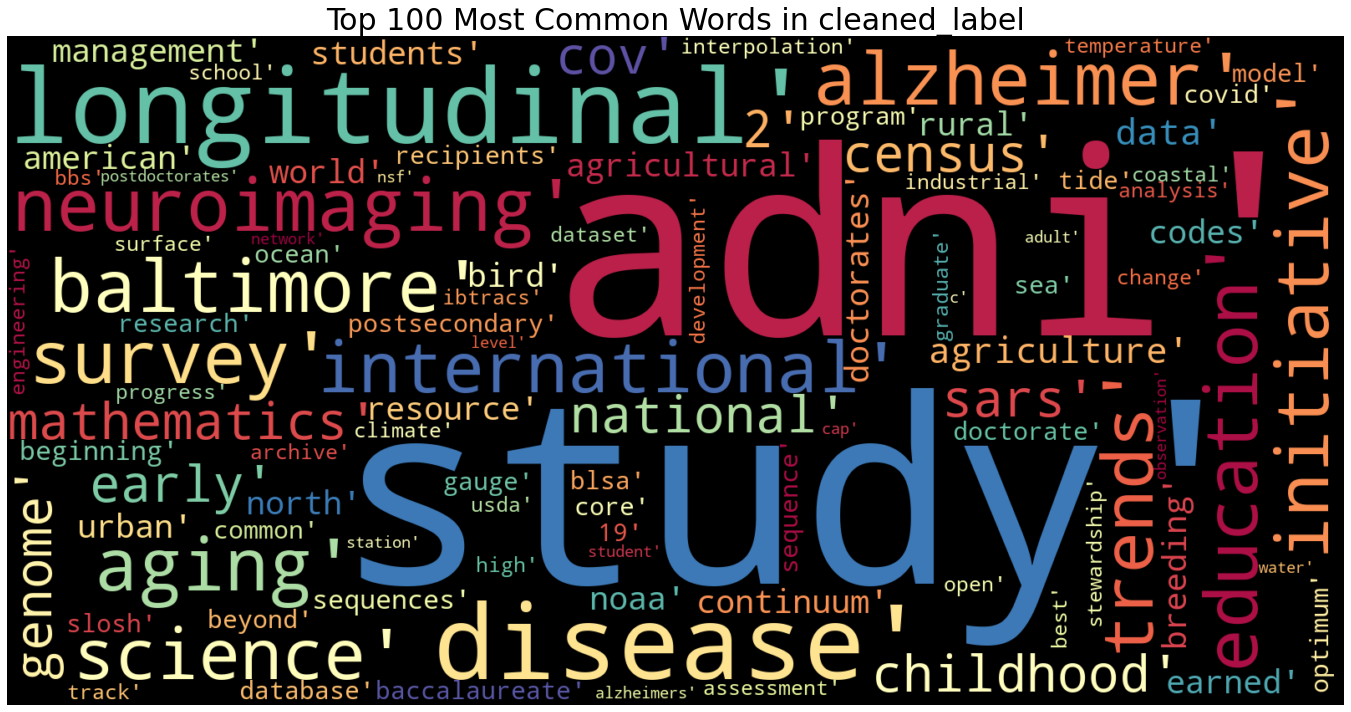

In [46]:
#plot frequency distributions
wordcloud = WordCloud(width = 1600, height = 800, 
                      background_color = 'black', 
                      colormap = 'Spectral', 
                      stopwords = stopwords_list).generate(str(mostcommon))

fig = plt.figure(figsize = (20, 10), facecolor = 'white')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.title('Top 100 Most Common Words in cleaned_label', fontsize = 30)
plt.tight_layout()

#save
plt.savefig('cleaned_label_wordcloud.png')

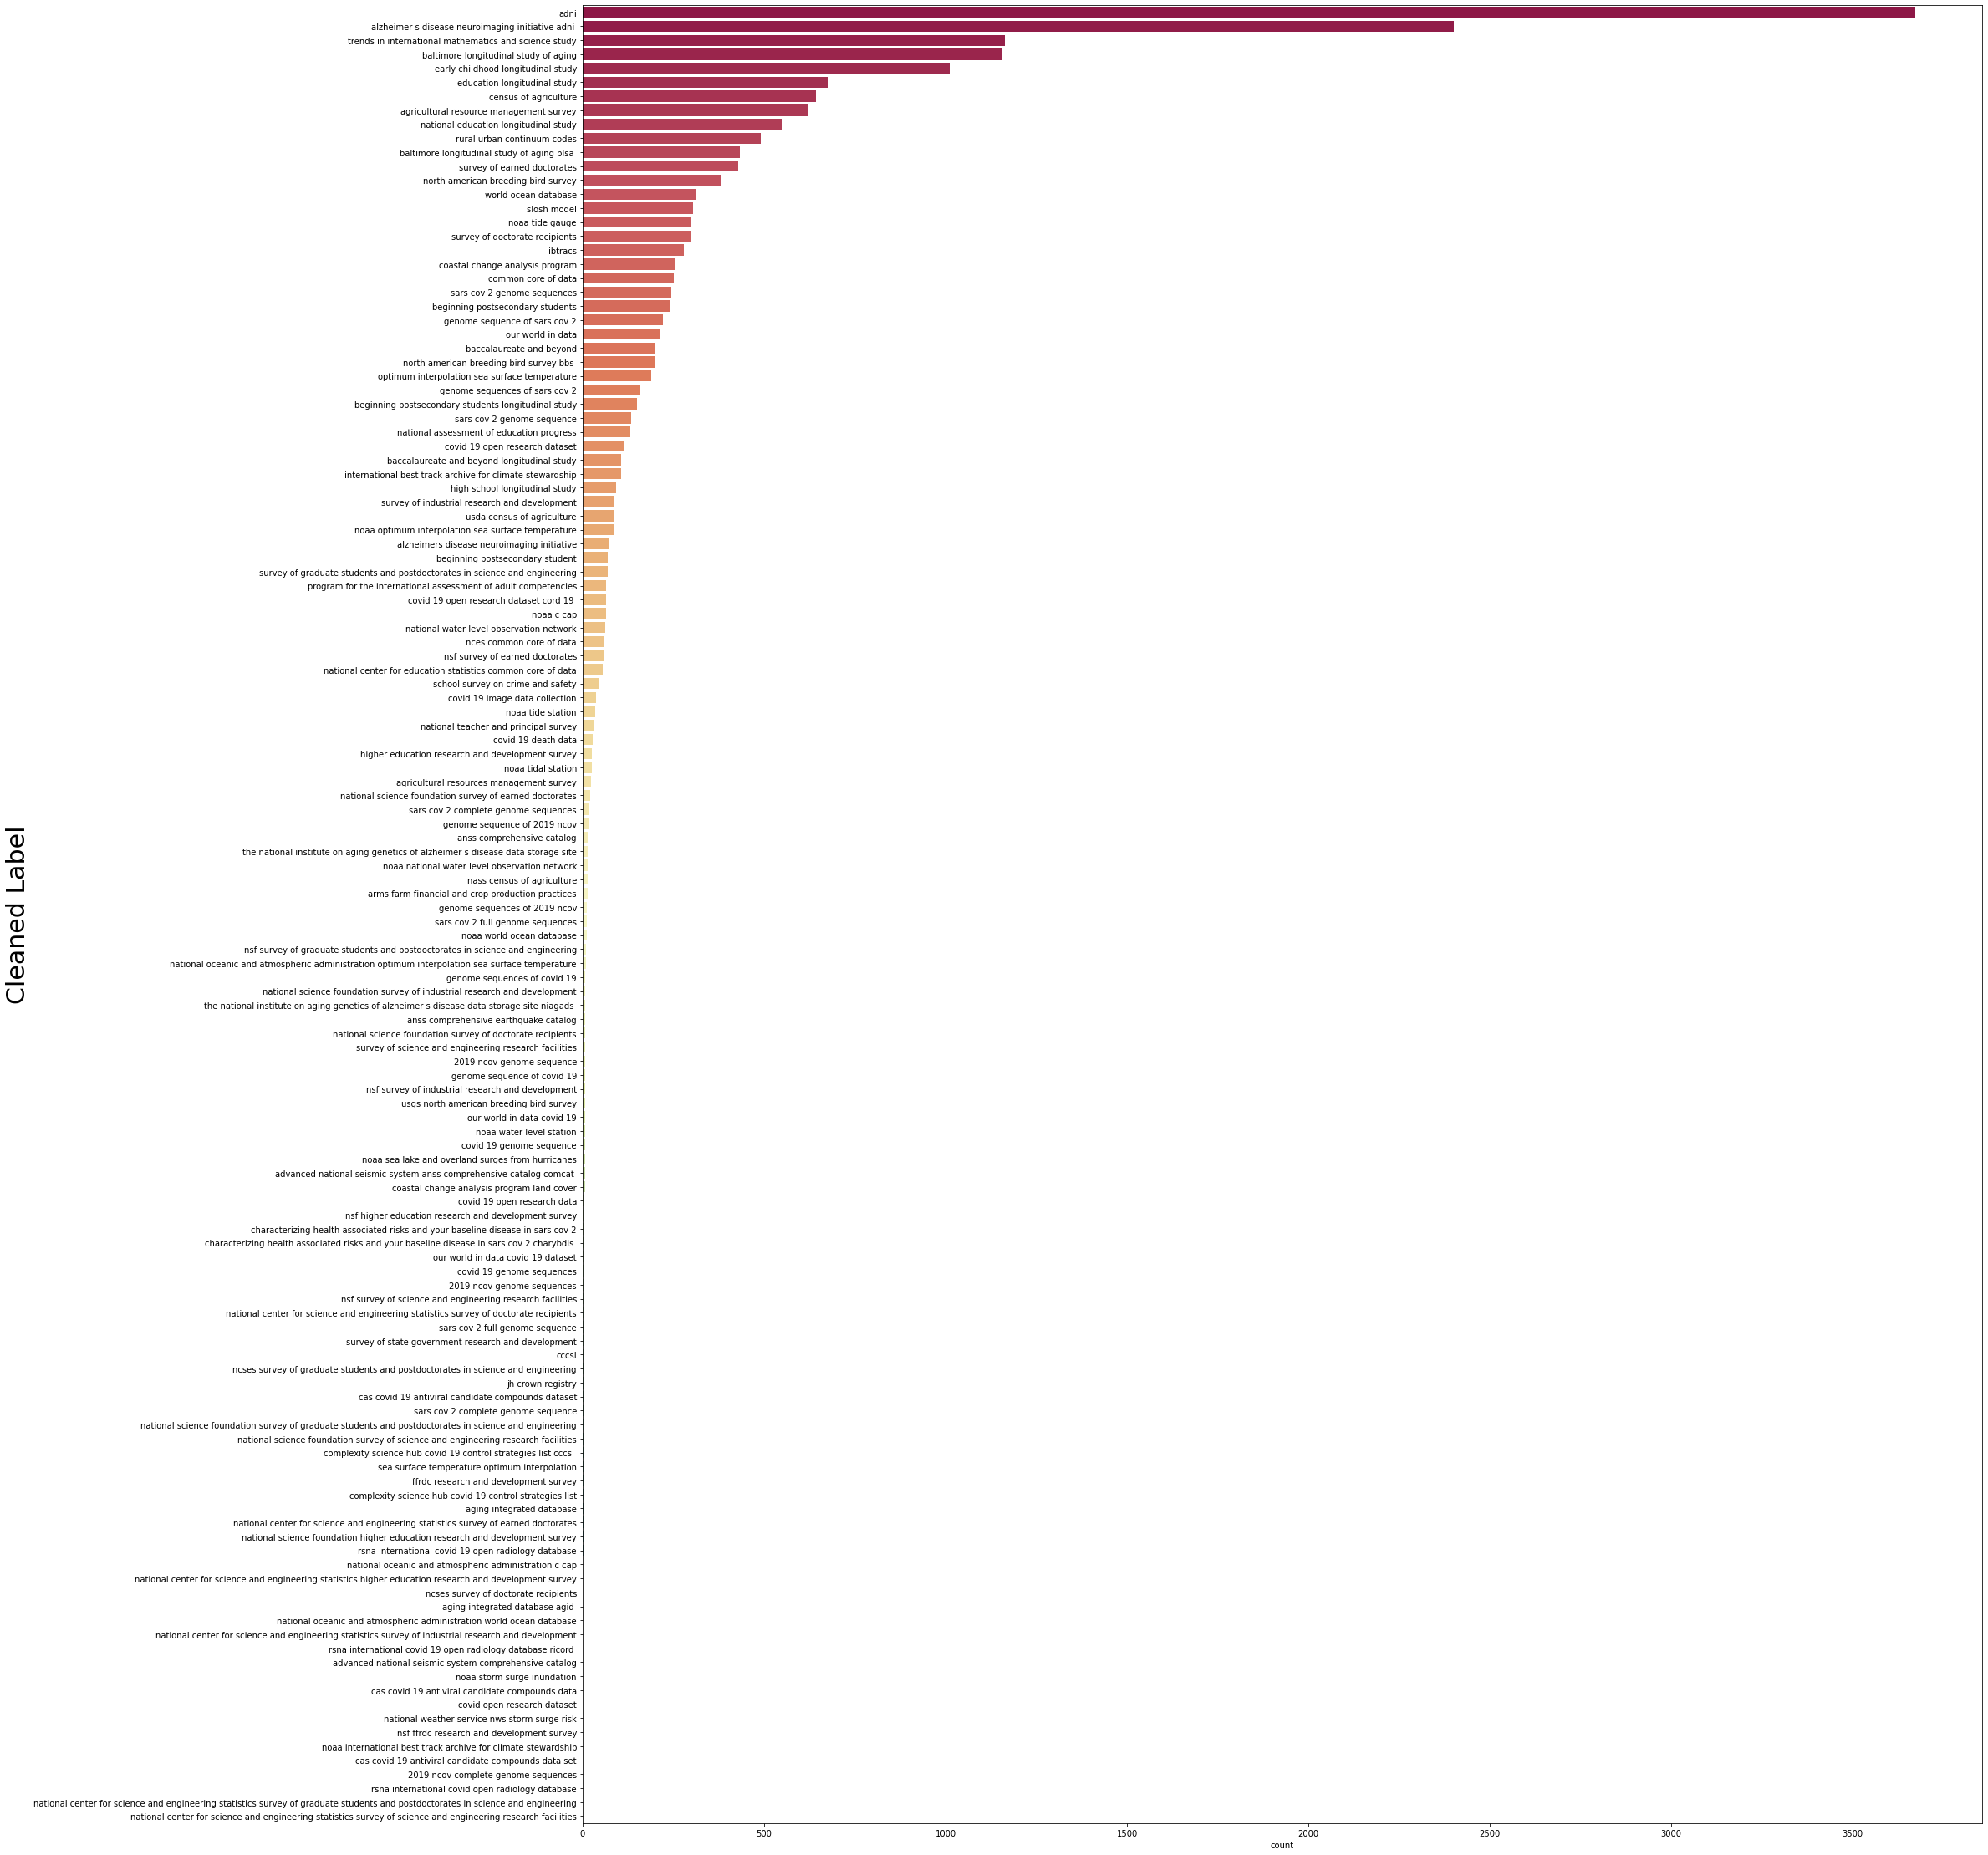

<Figure size 432x288 with 0 Axes>

In [47]:
plt.figure(figsize = (30, 40)),

sns.countplot(y = train_df['cleaned_label'], 
              order = train_df['cleaned_label'].value_counts().index, 
              palette = 'Spectral')
plt.ylabel('Cleaned Label',fontsize = 30)
plt.show()

#save
plt.savefig('cleaned_label.png')

The classes are highly imbalanced.

## BiGram

An n-gram means a sequence of n-words.

Some English words occur together more frequently. So, in a text document we may need to identify such pair of words which will help in sentiment analysis. 

Bigram is 2 consecutive words in a sentence.

In [48]:
from sklearn.feature_extraction.text import CountVectorizer

#get bigrams 
vectorizer = CountVectorizer(ngram_range = (2, 2))

#matrix of ngrams
ngrams = vectorizer.fit_transform(train_df['cleaned_label']) 
features = (vectorizer.get_feature_names())
print('\n\nFeatures : \n', features)

#count frequency of ngrams
print('\n\nX1 : \n', ngrams.toarray())
  
#apply TFIDF
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range = (2, 2))
ngrams = vectorizer.fit_transform(train_df['cleaned_label'])
scores = (ngrams.toarray())
print('\n\nScores : \n', scores)
  
#get top ranking features
sums = ngrams.sum(axis = 0)
data1 = []
for col, term in enumerate(features):
    data1.append( (term, sums[0,col] ))
ranking = pd.DataFrame(data1, columns = ['term','rank'])
words = (ranking.sort_values('rank', ascending = False))
print ('\n\nWords head : \n', words.head(20))



Features : 
 ['19 antiviral', '19 control', '19 dataset', '19 death', '19 genome', '19 image', '19 open', '2019 ncov', 'administration cap', 'administration optimum', 'administration world', 'adult competencies', 'advanced national', 'aging blsa', 'aging genetics', 'aging integrated', 'agricultural resource', 'agricultural resources', 'alzheimer disease', 'alzheimers disease', 'american breeding', 'analysis program', 'and atmospheric', 'and beyond', 'and crop', 'and development', 'and engineering', 'and overland', 'and postdoctorates', 'and principal', 'and safety', 'and science', 'and your', 'anss comprehensive', 'antiviral candidate', 'archive for', 'arms farm', 'assessment of', 'associated risks', 'atmospheric administration', 'baccalaureate and', 'baltimore longitudinal', 'baseline disease', 'beginning postsecondary', 'best track', 'beyond longitudinal', 'bird survey', 'breeding bird', 'candidate compounds', 'cas covid', 'catalog comcat', 'census of', 'center for', 'change analys

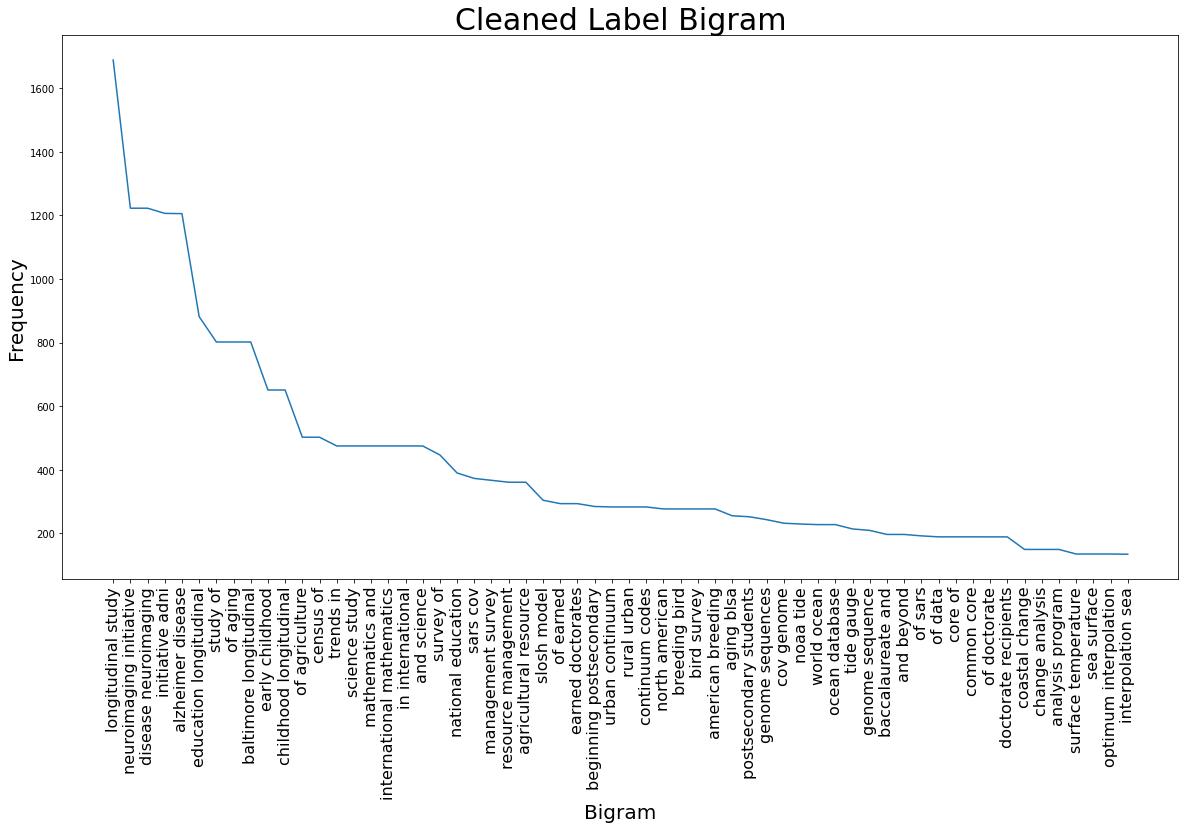

<Figure size 432x288 with 0 Axes>

In [49]:
#count frequency of ngrams
count_values = ngrams.toarray().sum(axis = 0)

#list of ngrams
vocab = vectorizer.vocabulary_
df_bigram = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse = True)
            ).rename(columns = {0: 'frequency', 1: 'bigram'})

plt.figure(figsize = (20, 10))
sns.lineplot(x = df_bigram['bigram'][:60], y = df_bigram['frequency'][:60])
plt.xticks(rotation = 90, fontsize = 16)
plt.xlabel('Bigram',fontsize = 20)
plt.ylabel('Frequency',fontsize = 20)
plt.title('Cleaned Label Bigram',fontsize = 30)
plt.show()

#save
plt.savefig('cleaned_label bigram.png')

## TriGram

Trigram is 3 consecutive words in a sentence. 

In [50]:
#get trigrams 
vectorizer = CountVectorizer(ngram_range = (3, 3))

#matrix of ngrams
ngrams = vectorizer.fit_transform(train_df['cleaned_label']) 
features = (vectorizer.get_feature_names())
print('\n\nFeatures : \n', features)

#count frequency of ngrams
print('\n\nX1 : \n', ngrams.toarray())
  
#apply TFIDF
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range = (3, 3))
ngrams = vectorizer.fit_transform(train_df['cleaned_label'])
scores = (ngrams.toarray())
print('\n\nScores : \n', scores)
  
#get top ranking features
sums = ngrams.sum(axis = 0)
data1 = []
for col, term in enumerate(features):
    data1.append( (term, sums[0,col] ))
ranking = pd.DataFrame(data1, columns = ['term','rank'])
words = (ranking.sort_values('rank', ascending = False))
print ('\n\nWords head : \n', words.head(20))



Features : 
 ['19 antiviral candidate', '19 control strategies', '19 death data', '19 genome sequence', '19 genome sequences', '19 image data', '19 open radiology', '19 open research', '2019 ncov complete', '2019 ncov genome', 'administration optimum interpolation', 'administration world ocean', 'advanced national seismic', 'aging genetics of', 'aging integrated database', 'agricultural resource management', 'agricultural resources management', 'alzheimer disease data', 'alzheimer disease neuroimaging', 'alzheimers disease neuroimaging', 'american breeding bird', 'analysis program land', 'and atmospheric administration', 'and beyond longitudinal', 'and crop production', 'and development survey', 'and engineering research', 'and engineering statistics', 'and overland surges', 'and postdoctorates in', 'and principal survey', 'and science study', 'and your baseline', 'anss comprehensive catalog', 'anss comprehensive earthquake', 'antiviral candidate compounds', 'archive for climate', 'a

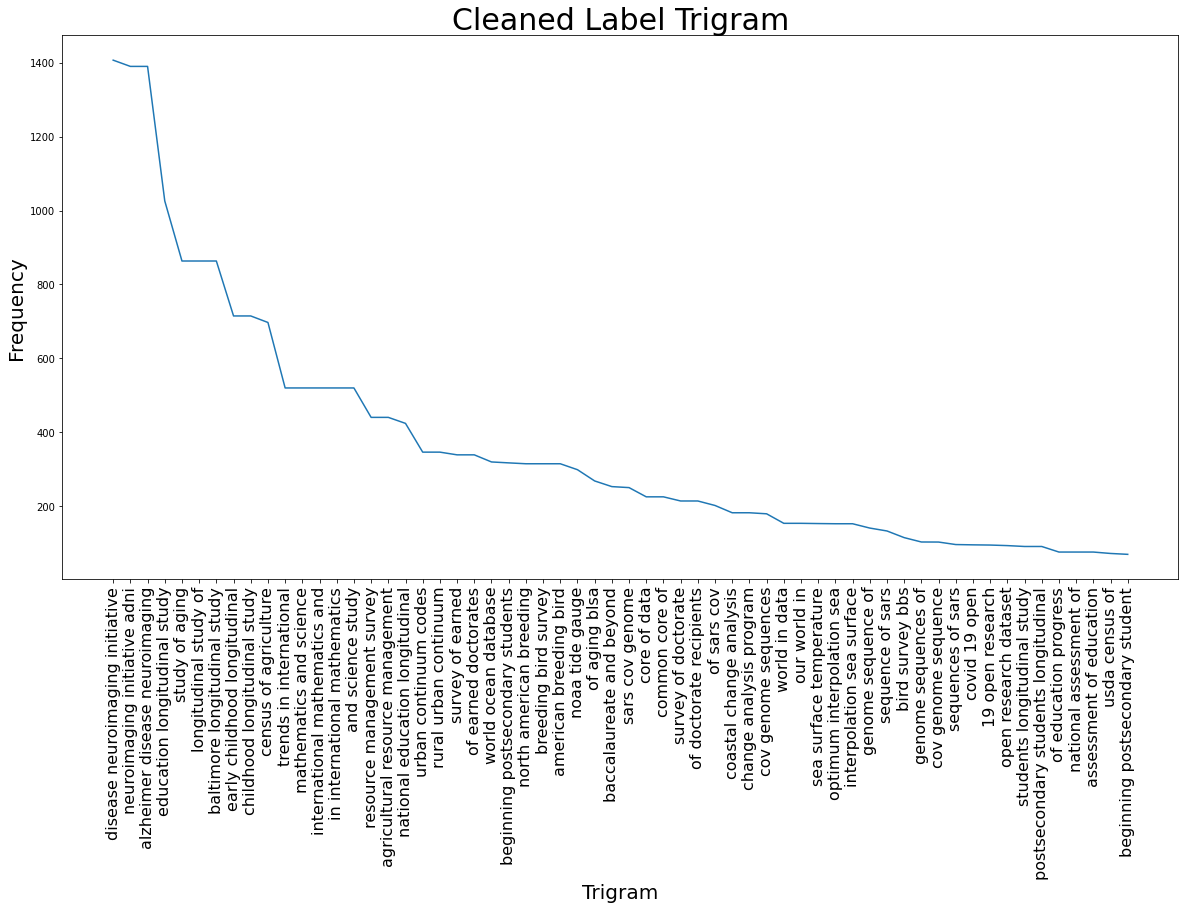

<Figure size 432x288 with 0 Axes>

In [51]:
#count frequency of ngrams
count_values = ngrams.toarray().sum(axis = 0)

#list of ngrams
vocab = vectorizer.vocabulary_
df_trigram = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse = True)
            ).rename(columns = {0: 'frequency', 1:'trigram'})

plt.figure(figsize = (20, 10))
sns.lineplot(x = df_trigram['trigram'][:60], y = df_trigram['frequency'][:60])
plt.xticks(rotation = 90, fontsize = 16)
plt.xlabel('Trigram',fontsize = 20)
plt.ylabel('Frequency',fontsize = 20)
plt.title('Cleaned Label Trigram',fontsize = 30)
plt.show()

#save
plt.savefig('cleaned_label trigram.png')

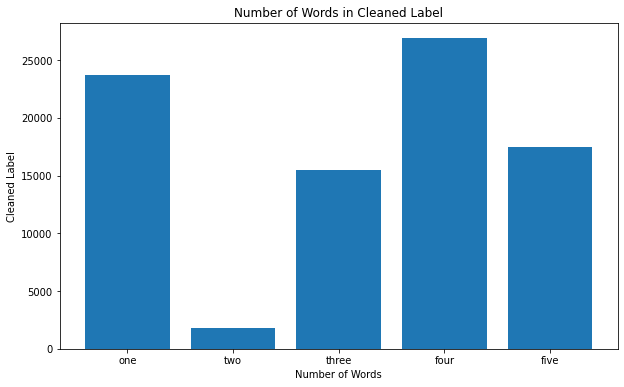

In [52]:
#find one-worded, two-worded, three-worded, four-worded, five-worded dataset title
one_worded_cleaned_label = train_df[train_df['cleaned_label'].str.split().apply(len) == 1]
two_worded_cleaned_label = train_df[train_df['cleaned_label'].str.split().apply(len) == 2]
three_worded_cleaned_label = train_df[train_df['cleaned_label'].str.split().apply(len) == 3]
four_worded_cleaned_label = train_df[train_df['cleaned_label'].str.split().apply(len) == 4]
five_worded_cleaned_label = train_df[train_df['cleaned_label'].str.split().apply(len) == 5]

#create a bar plot
fig, ax = plt.subplots(figsize = (10, 6))
ax.bar([1, 2, 3, 4, 5], [one_worded_cleaned_label.size,
                         two_worded_cleaned_label.size,
                         three_worded_cleaned_label.size,
                         four_worded_cleaned_label.size,
                         five_worded_cleaned_label.size])

#label the x-axis instances
ax.set_xticks([1, 2, 3, 4, 5])
ax.set_xticklabels(["one", "two", "three", 'four', 'five'])

# set the title and the xy-axis labels
plt.title("Number of Words in Cleaned Label")
plt.xlabel("Number of Words")
plt.ylabel("Cleaned Label")

# display the plot
plt.show()

# SENTIMENT ANALYSIS

TextBlob is another excellent open-source library for performing NLP tasks with ease, including sentiment analysis. It also an a sentiment lexicon (in the form of an XML file) which it leverages to give both polarity and subjectivity scores. The polarity score is a float within the range [-1.0, 1.0]. The subjectivity is a float within the range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective.

In [53]:
from textblob import TextBlob

#get texxt sentiment
train_df['text_sentiment'] = train_df['text'].apply(lambda x: TextBlob(x).sentiment.polarity)

#review
train_df.head(5)

Id  \
0  d0fa7568-7d8e-4db9-870f-f9c6f668c17b   
1  2f26f645-3dec-485d-b68d-f013c9e05e60   
2  c5d5cd2c-59de-4f29-bbb1-6a88c7b52f29   
3  5c9a3bc9-41ba-4574-ad71-e25c1442c8af   
4  c754dec7-c5a3-4337-9892-c02158475064   

                                           pub_title  \
0  the impact of dual enrollment on college degre...   
1  educational attainment of high school dropout ...   
2  difference in outcome for female and male stud...   
3  stepping stone and option value in a model of ...   
4  parental effort school resource and student ac...   

                           dataset_title  \
0  national education longitudinal study   
1  national education longitudinal study   
2  national education longitudinal study   
3  national education longitudinal study   
4  national education longitudinal study   

                           dataset_label  \
0  National Education Longitudinal Study   
1  National Education Longitudinal Study   
2  National Education Longitudinal Study   
3  National Education Longitudinal Study   
4  National Education Longitudinal Study   

                           cleaned_label  \
0  national education longitudinal study   
1  national education longitudinal study   
2  national education longitudinal study   
3  national education longitudinal study   
4  national education longitudinal study   

                                                text  text_sentiment  
0  this study used data from the national educati...        0.041849  
1  dropping out of high school is not necessarily...        0.077153  
2  stress satisfactory outcome for all youth incl...        0.114600  
3  federal reserve bank of richmond s1 accounting...        0.047667  
4  this article investigates an important factor ...        0.076616

In [54]:
from textblob import TextBlob

#get text tag
train_df['dataset_title_tag'] = train_df['dataset_title'].apply(lambda x: TextBlob(x).tags)

#review
train_df.head(5)

Id  \
0  d0fa7568-7d8e-4db9-870f-f9c6f668c17b   
1  2f26f645-3dec-485d-b68d-f013c9e05e60   
2  c5d5cd2c-59de-4f29-bbb1-6a88c7b52f29   
3  5c9a3bc9-41ba-4574-ad71-e25c1442c8af   
4  c754dec7-c5a3-4337-9892-c02158475064   

                                           pub_title  \
0  the impact of dual enrollment on college degre...   
1  educational attainment of high school dropout ...   
2  difference in outcome for female and male stud...   
3  stepping stone and option value in a model of ...   
4  parental effort school resource and student ac...   

                           dataset_title  \
0  national education longitudinal study   
1  national education longitudinal study   
2  national education longitudinal study   
3  national education longitudinal study   
4  national education longitudinal study   

                           dataset_label  \
0  National Education Longitudinal Study   
1  National Education Longitudinal Study   
2  National Education Longitudinal Study   
3  National Education Longitudinal Study   
4  National Education Longitudinal Study   

                           cleaned_label  \
0  national education longitudinal study   
1  national education longitudinal study   
2  national education longitudinal study   
3  national education longitudinal study   
4  national education longitudinal study   

                                                text  text_sentiment  \
0  this study used data from the national educati...        0.041849   
1  dropping out of high school is not necessarily...        0.077153   
2  stress satisfactory outcome for all youth incl...        0.114600   
3  federal reserve bank of richmond s1 accounting...        0.047667   
4  this article investigates an important factor ...        0.076616   

                                   dataset_title_tag  
0  [(national, JJ), (education, NN), (longitudina...  
1  [(national, JJ), (education, NN), (longitudina...  
2  [(national, JJ), (education, NN), (longitudina...  
3  [(national, JJ), (education, NN), (longitudina...  
4  [(national, JJ), (education, NN), (longitudina...

In [55]:
#save
train_df.to_csv('train_df_tag.csv')